#Covid Data Exploration and Preprocessing

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import math
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

Please load the raw csv data


Saving virus_data.csv to virus_data.csv


## Loading the dataset

In [14]:
dataset = pd.read_csv(filename)
random = 5 + 9
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state = random)

## Grouping columns of the dataset by their characteristics and similarity:
###- continuous, discrete, positive.

In [15]:
pcr_list = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
pcr_positive = ['PCR_03', 'PCR_04','PCR_05','PCR_10']
pcr_dis = ['PCR_05', 'PCR_10']
pcr_con = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09']

COL_CONT = ['age', 'weight', 'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
COL_TARGET = ['spread', 'risk', 'covid']
COL_NOT_USED = ['patient_id', 'address', 'current_location', 'job', 'pcr_date']
COL_CAT = ['conversations_per_day', 'happiness_score', 'num_of_siblings', 'sport_activity']
COLS = 3

## Generating new features:
### extracting valuable information from the address of a patient, date of a test, current location, one hot transformations for categorical variables.

In [16]:
import re

def extract_state(addr):
  if len(addr.split(', ')) > 1 and len(addr.split(', ')[1].split(' ')[0]) == 2:
    return addr.split(', ')[1].split(' ')[0]
  elif addr != 'nan':
    return 'USAF'
  else:
      return addr

def extract_zip(addr):
  if len(addr.split(' ')) > 0:
    zipstr = addr.split(' ')[len(addr.split(' '))-1] 
    if zipstr == 'nan':
      return 1
    return int(addr.split(' ')[len(addr.split(' '))-1])
  else:
      return int(addr)

#date to number of days:
from datetime import date
def dateToDays(pcr_date):
  if pcr_date != 'nan':
    splitted = pcr_date.split('-')
    d0 = date(2020, 1, 1)
    d1 = date(int(splitted[0]), int(splitted[1]), int(splitted[2]))
    delta = d1 - d0
    return delta.days
  else:
    return np.nan

def extract_x(loc):
  if len(loc.split(', ')) > 1:
    x = loc.strip('()').split(', ')[0].strip('\'\'')
    return np.float64(x)
  else:
    return np.nan

def extract_y(loc):
  if len(loc.split(', ')) > 1:
    x = loc.strip('()').split(', ')[1].strip('\'\'')
    return np.float64(x)
  else:
    return np.nan

def genCatConst(col, min, max, step):
  col_groups = np.arange(min, max, step)
  train_data[col+"_g"] = pd.cut(train_data[col], col_groups, include_lowest = True)

def genCat(col, step):
  min = int(math.floor(train_data[col].min()))
  max = int(math.ceil (train_data[col].max()))
  col_groups = np.arange(min, max + step + 1, step)
  train_data[col+"_g"] = pd.cut(train_data[col], col_groups, include_lowest = True)

def genGroups():
  genCat('weight', 5)
  genCat('household_income', 75)
  genCat('sugar_levels', 5)
  genCat('days', 20)
  genCatConst('zip', 501, 101502, 1000)
  genCat('PCR_01', 0.1)
  genCat('PCR_02', 0.1)
  genCat('PCR_03', 20)
  genCat('PCR_04', 20)
  genCat('PCR_06', 1)
  genCat('PCR_07', 1.5)
  genCat('PCR_08', 0.5)
  genCat('PCR_09', 0.5)

# Transform categorical features into OHE

symptoms_ohe = train_data['symptoms'].str.get_dummies(sep=";")
train_data.drop(labels=['symptoms'], axis=1, inplace=True)
train_data = train_data.join(symptoms_ohe)

sex_ohe = pd.get_dummies(train_data['sex'])
train_data = train_data.join(sex_ohe)
train_data.drop(labels=['sex'], axis=1, inplace=True)

# Extract new features from other features:

train_data['zip']   = train_data['address'].astype(str).apply(lambda x : extract_zip(x))
train_data['x'] = train_data['current_location'].astype(str).apply(lambda x : extract_x(x))
train_data['y'] = train_data['current_location'].astype(str).apply(lambda x : extract_y(x))
train_data['days'] = train_data['pcr_date'].astype(str).apply(lambda x : dateToDays(x))
# Add groups for categorical data:
genGroups()

orig_data = cp.deepcopy(train_data) 

## Bivariate analysis of the data.
### Bivariate distributions visualization:

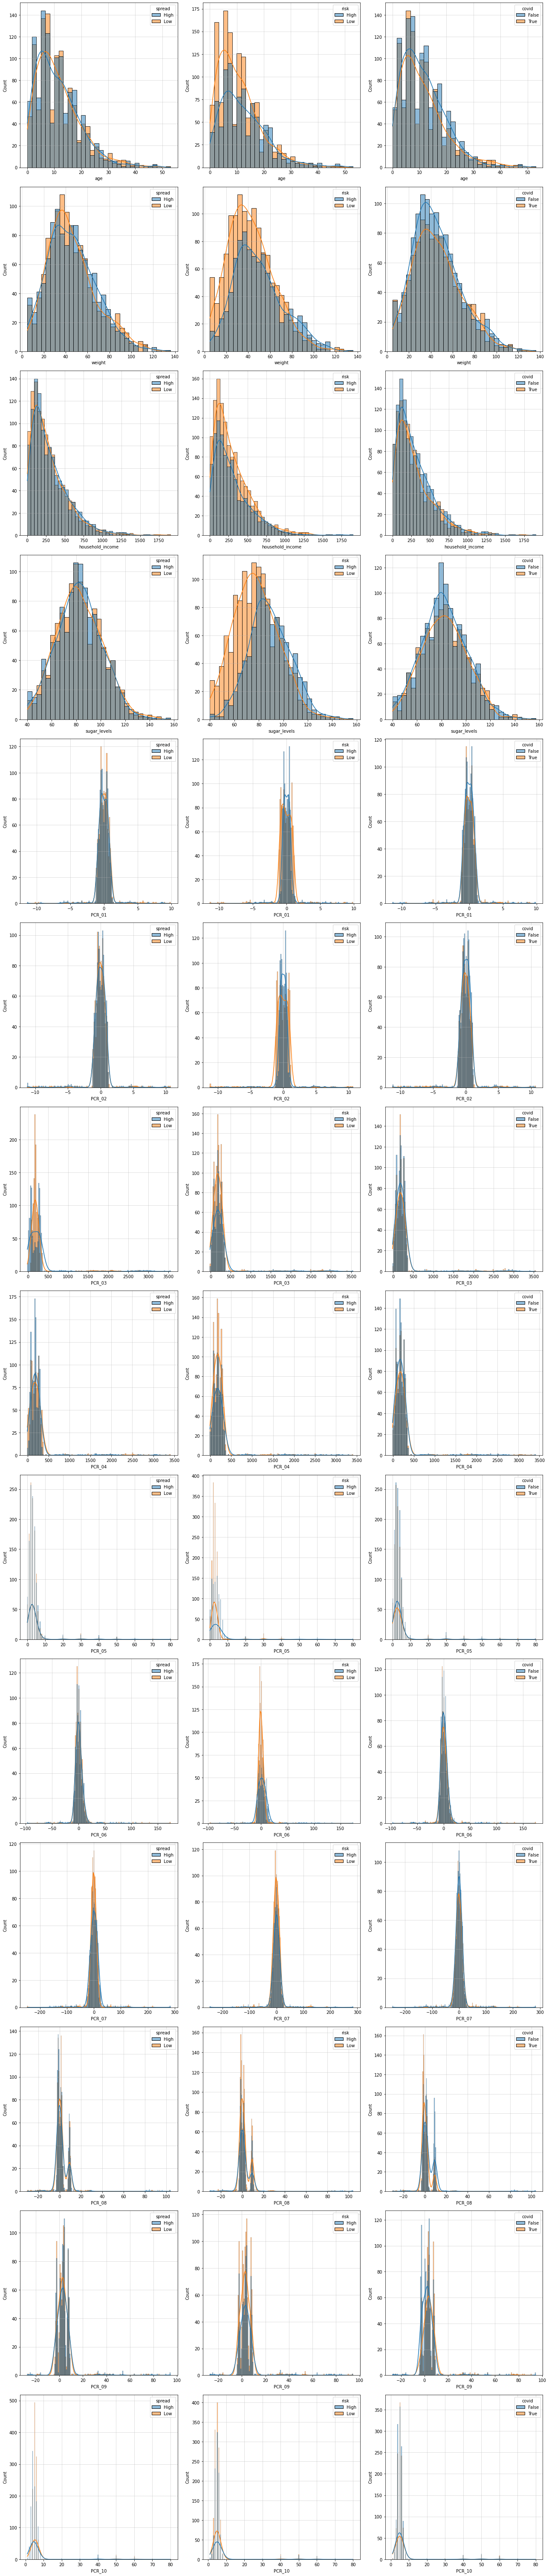

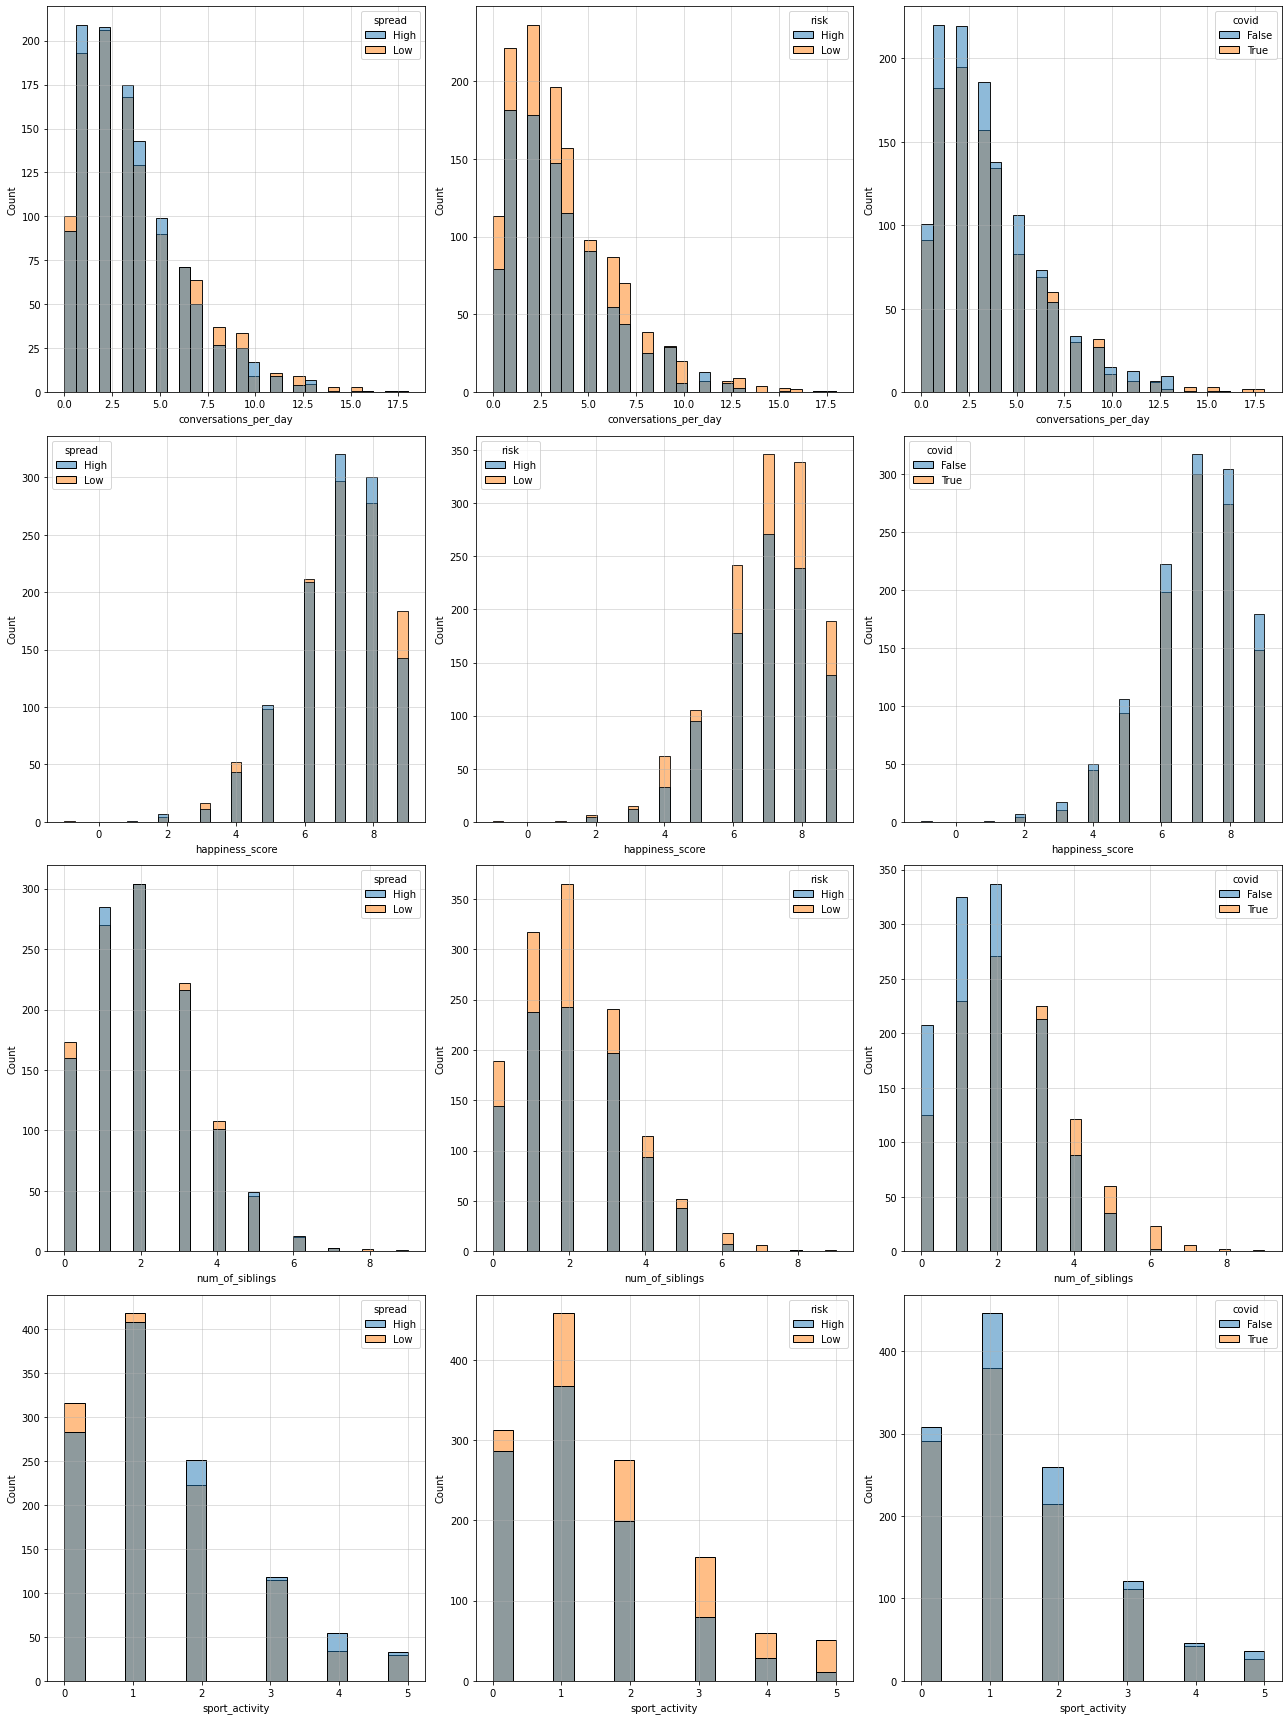

In [17]:
#CONTINUOUS COLUMNS:
ROWS = len(COL_CONT)

plt.figure(figsize=(18, 6 * ROWS))
for i, column in enumerate(COL_CONT, 1):
  for j, target in enumerate(COL_TARGET, 1):
     plt.subplot(ROWS, COLS, (i-1)*3 + j)
     sns.histplot(data=train_data, hue=target, x=column, multiple='layer', kde=True)
     plt.grid(alpha=0.5)

plt.tight_layout()

#OTHER COLUMNS:
ROWS = len(COL_CAT)

plt.figure(figsize=(18, 6 * ROWS))
for i, column in enumerate(COL_CAT, 1):
  for j, target in enumerate(COL_TARGET, 1):
     plt.subplot(ROWS, COLS, (i-1)*3 + j)
     sns.histplot(data=train_data, hue=target, x=column, multiple='layer')
     plt.grid(alpha=0.5)

plt.tight_layout()


## Searching for possible outliers distribution:

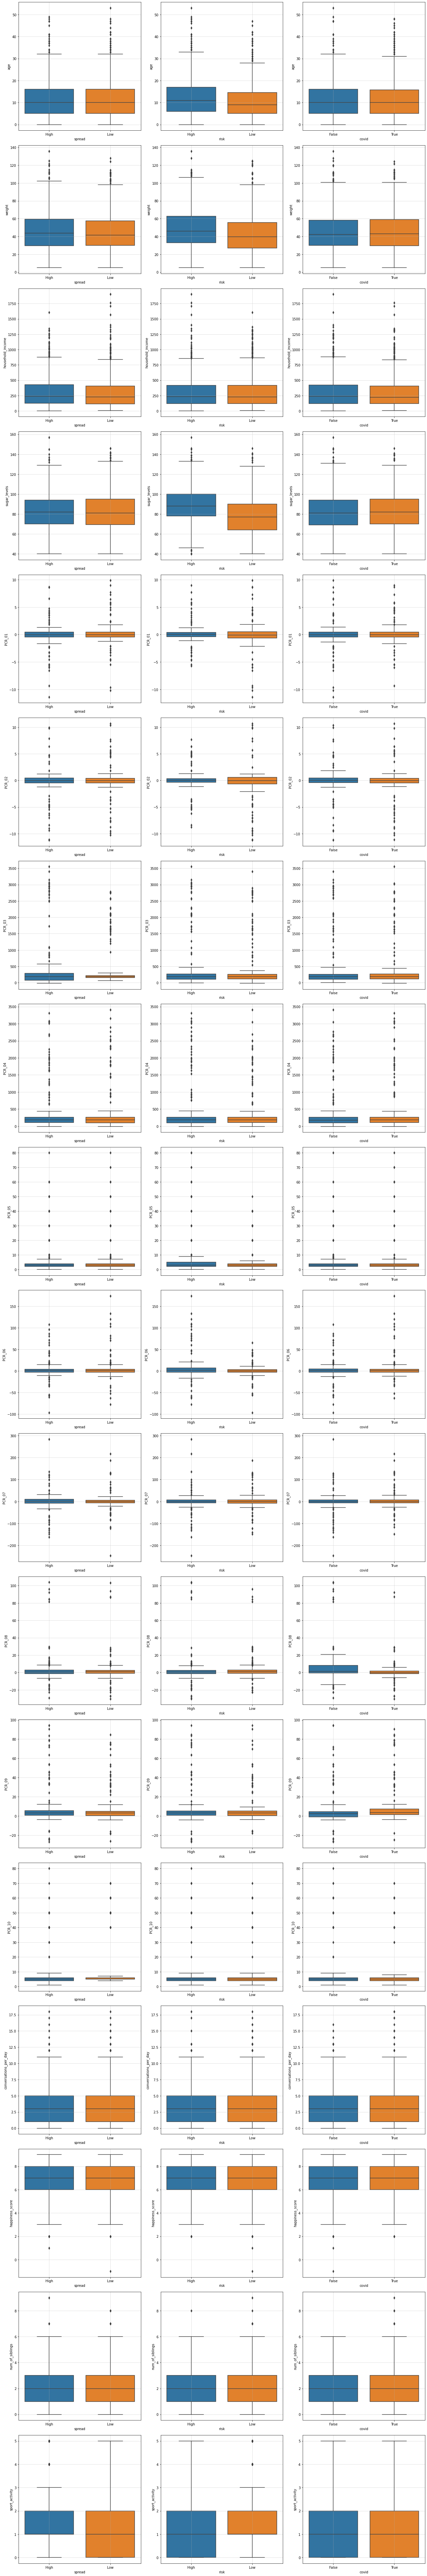

In [18]:
def histograms(data):
  columns = COL_CONT + COL_CAT
  COLS = 3
  ROWS = len(columns)
  plt.figure(figsize=(18, 2 * ROWS))
  for i, column in enumerate(columns, 1):
    plt.subplot(ROWS, COLS, i )
    sns.histplot(data = data , x = column, kde=True)
    plt.grid(alpha=0.5)

  plt.tight_layout()

def boxPlots(data):
  columns = COL_CONT + COL_CAT
  COLS = len(COL_TARGET)
  ROWS = len(columns)
  plt.figure(figsize=(18, 6 * ROWS))

  for i, column in enumerate(columns, 1):
    for j, target in enumerate(COL_TARGET, 1):
      plt.subplot(ROWS, COLS, (i-1)*len(COL_TARGET) + j)
      sns.boxplot(data = data,  x= target, y = column)
      plt.grid(alpha=0.5)
  plt.tight_layout()

boxPlots(train_data)


## Findings of bivariate analysis:

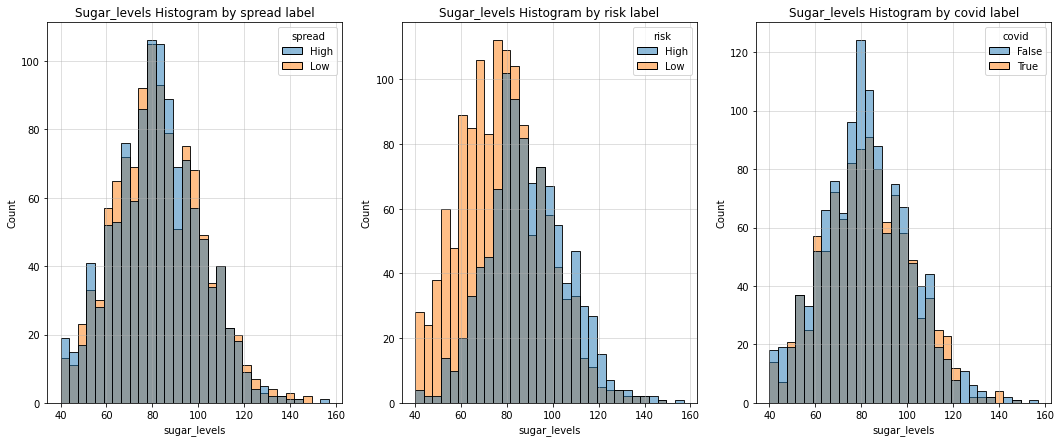

In [19]:
plt.figure(figsize=(18,7))
plt.subplot(1,3,1)
sns.histplot(data=orig_data, x='sugar_levels', hue='spread').set_title('Sugar_levels Histogram by spread label')
plt.grid(alpha=0.5)
plt.subplot(1,3,2)
sns.histplot(data=orig_data, x='sugar_levels', hue='risk').set_title('Sugar_levels Histogram by risk label')
plt.grid(alpha=0.5)
plt.subplot(1,3,3)
sns.histplot(data=orig_data, x='sugar_levels', hue='covid').set_title('Sugar_levels Histogram by covid label')
plt.grid(alpha=0.5)

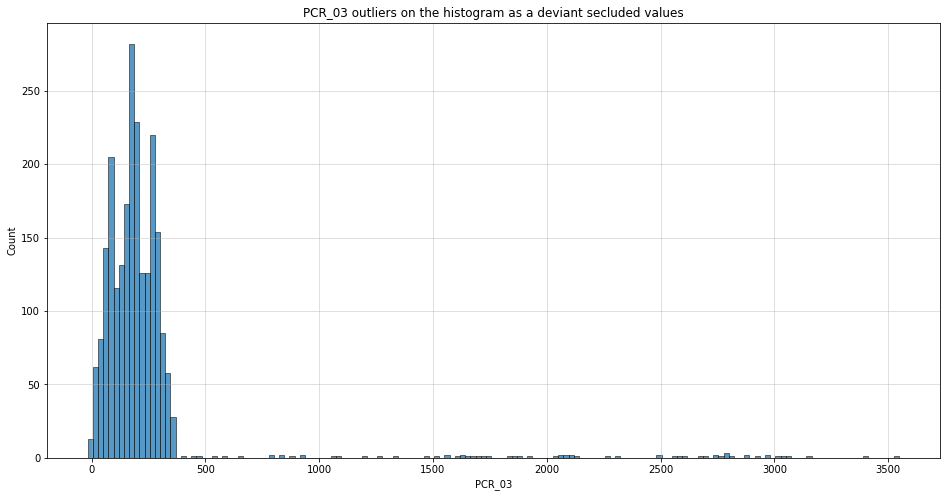

In [20]:
plt.figure(figsize=(16,8))
sns.histplot(data=orig_data, x='PCR_03').set_title('PCR_03 outliers on the histogram as a deviant secluded values')
plt.grid(alpha=0.5)

## Outlier Detection

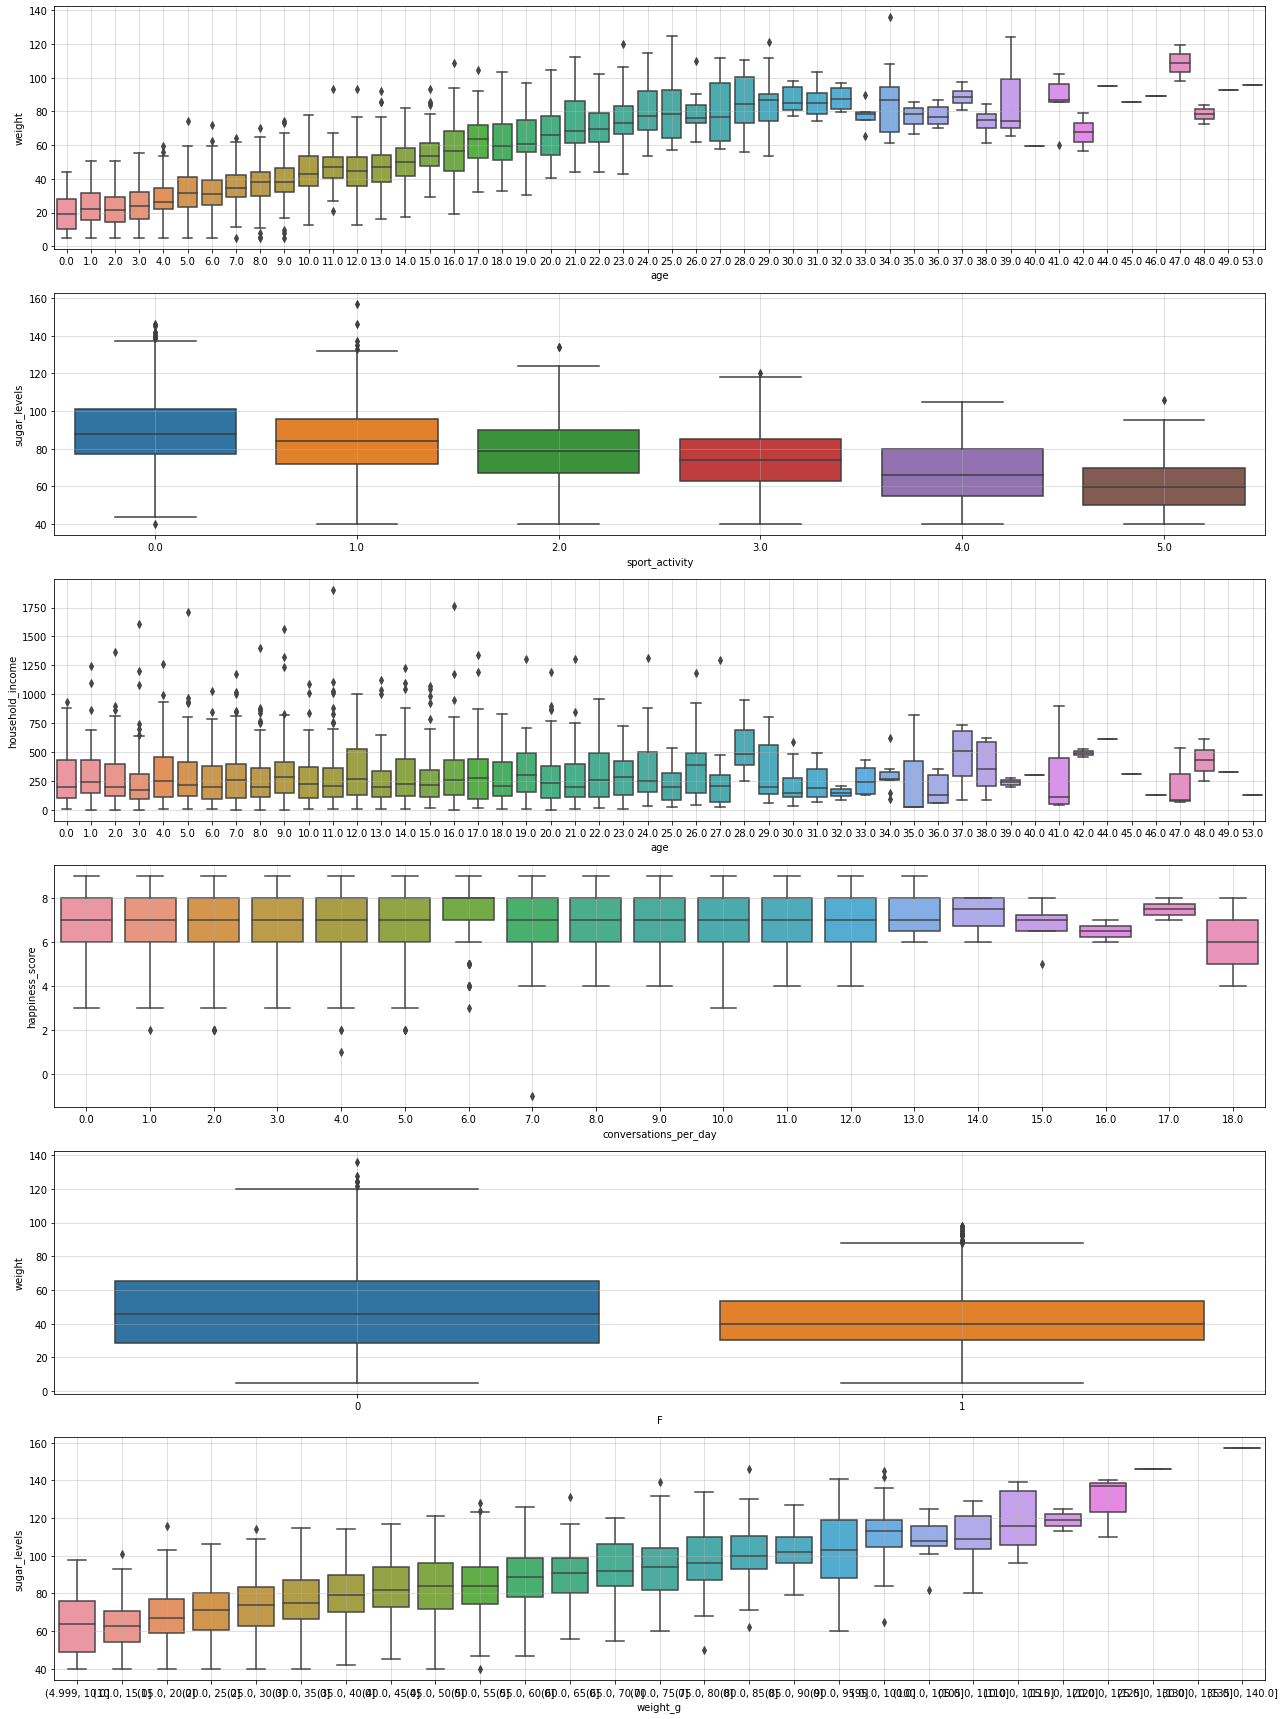

In [21]:
outliers_pairs = [('age', 'weight'), ('sport_activity', 'sugar_levels'), ('age', 'household_income'), ('conversations_per_day', 'happiness_score'), ('F', 'weight'), ('weight_g', 'sugar_levels')]
out_rows = 6
out_cols = 1
plt.figure(figsize=(18, 6 * ROWS))

for i in range(1, out_rows+1):
  plt.subplot(out_rows, out_cols, i)
  sns.boxplot(data = orig_data,  x = outliers_pairs[i - 1][0], y = outliers_pairs[i - 1][1])
  plt.grid(alpha=0.5)
plt.tight_layout()

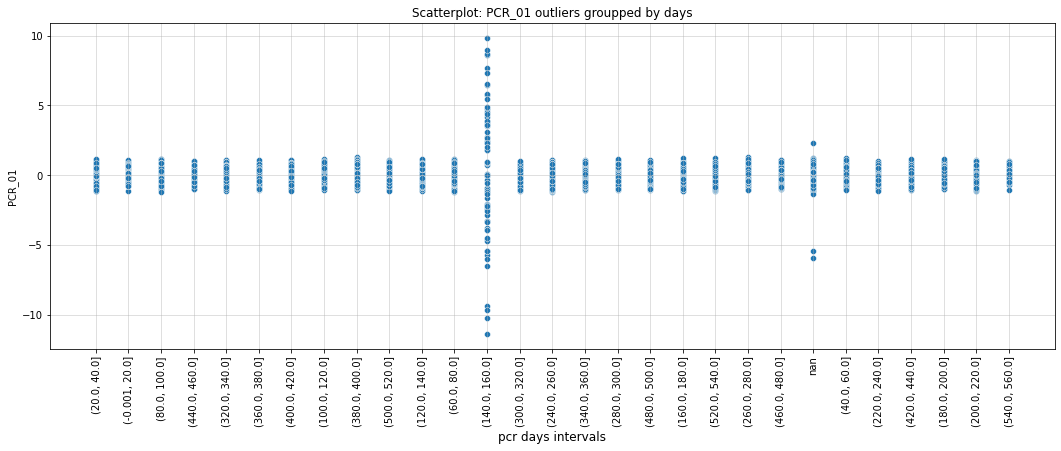

In [22]:
plt.figure(figsize=(18,6))
g = sns.scatterplot(x=train_data['days_g'].astype(str), y = train_data['PCR_01']).set_title('Scatterplot: PCR_01 outliers groupped by days')
plt.xlabel('pcr days intervals', fontsize=12)
plt.xticks(rotation=90)
plt.grid(alpha=0.5)

## Outlier treatment:

In [23]:

def q25(x):
  return x.quantile(0.25)

def q75(x):
  return x.quantile(0.75)
  
def cleanIQR(col, toClean, to_round = False):
  q1 = train_data.groupby([col]).agg({toClean:[q25]})
  q3 = train_data.groupby([col]).agg({toClean:[q75]})
  q1 = q1[toClean]['q25']
  q3 = q3[toClean]['q75']
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr
  lower = lower.where(lower > 0, 0)
  for i, row in train_data.iterrows():
    colVal = train_data.at[i, col]
    toCleanVal = train_data.at[i, toClean]
    if (type(colVal) == pd._libs.interval.Interval) or (not math.isnan(colVal) and not math.isnan(toCleanVal)): 
      toCleanUpper = upper[colVal]
      toCleanLower = lower[colVal]
      if toCleanVal > toCleanUpper:
        train_data.at[i,toClean] = math.floor(toCleanUpper) if to_round else toCleanUpper
      elif toCleanVal < toCleanLower:
        train_data.at[i,toClean] = math.ceil(toCleanLower) if to_round else toCleanLower
      
def singleCleanIQR(to_clean, to_round = False):
  q1 = train_data[to_clean].quantile(0.25)
  q3 = train_data[to_clean].quantile(0.75)
  iqr = q3 - q1
  upper = q3 + 1.5*iqr
  lower = q1 - 1.5*iqr
  if to_round:
    upper = round(upper)
    lower = round(lower)
  for i, row in train_data.iterrows():
    toCleanVal = train_data.at[i, to_clean]
    if toCleanVal.astype(str) != 'nan': 
      if toCleanVal > upper:
        train_data.at[i,to_clean] = upper
      elif toCleanVal < lower:
        train_data.at[i,to_clean] = lower

def cleanZ(col, toClean):
  mean = train_data.groupby([col]).agg({toClean:[np.mean]})
  std = train_data.groupby([col]).agg({toClean:[np.std]})

  mean = mean[toClean]['mean']
  std = std[toClean]['std']

  upper = mean + 3*std
  lower = mean - 3*std
  for i, row in train_data.iterrows():
    colVal = train_data.at[i, col]
    toCleanVal = train_data.at[i, toClean]
    if (type(colVal) == pd._libs.interval.Interval) or (not math.isnan(colVal) and not math.isnan(toCleanVal)): 
      toCleanUpper = upper[colVal]
      toCleanLower = lower[colVal]
      if toCleanVal > toCleanUpper:
        train_data.at[i,toClean] = toCleanUpper
      elif toCleanVal < toCleanLower:
        train_data.at[i,toClean] = toCleanLower
def nanPercent(to_clean, quant1, quant2, to_round = False):
  lower = train_data[to_clean].quantile(quant1)
  upper = train_data[to_clean].quantile(quant2)
  if to_round:
    upper = round(upper)
    lower = round(lower)
  for i, row in train_data.iterrows():
    toCleanVal = train_data.at[i, to_clean]
    if toCleanVal.astype(str) != 'nan': 
      if toCleanVal > upper or toCleanVal < lower:
        train_data.at[i,to_clean] = 'nan'

def singleCleanZ(to_clean, to_round = False):
  mean = np.mean(train_data[to_clean])
  std =  np.std (train_data[to_clean])
  upper = mean + 3*std
  lower = mean - 3*std
  if to_round:
    upper = round(upper)
    lower = round(lower)
  for i, row in train_data.iterrows():
    toCleanVal = train_data.at[i, to_clean]
    if toCleanVal.astype(str) != 'nan': 
      if toCleanVal > upper:
        train_data.at[i,to_clean] = upper
      elif toCleanVal < lower:
        train_data.at[i,to_clean] = lower

def cleanBadDaysPCRs(bad_days, good_days, pcr):
  # They all have nan, so generate values based on good days
  bad_data = train_data[train_data.days_g == good_days]
  lower = bad_data.groupby(['days_g']).agg({pcr:[np.min]})
  upper = bad_data.groupby(['days_g']).agg({pcr:[np.max]})
  mean =  bad_data.groupby(['days_g']).agg({pcr:[np.mean]})
  std =   bad_data.groupby(['days_g']).agg({pcr:[np.std]})

  lower = lower[pcr]['amin'][good_days]
  upper = upper[pcr]['amax'][good_days]
  
  mean = mean[pcr]['mean'][good_days]
  std = std[pcr]['std'][good_days]

  for i, row in train_data[train_data.days_g == bad_days].iterrows():
    rnd = np.random.normal(mean, std)
    train_data.at[i, pcr] = round(rnd) if pcr in ['PCR_05', 'PCR_10'] else rnd # PCR_05, PCR_10 are discrete

def nanPCRs(bad_days):
  bad_days_data = train_data[train_data.days_g == bad_days]
  for i, row in bad_days_data.iterrows():
    for pcr in pcr_list:
      train_data.at[i, pcr] = 'nan'
  genGroups()


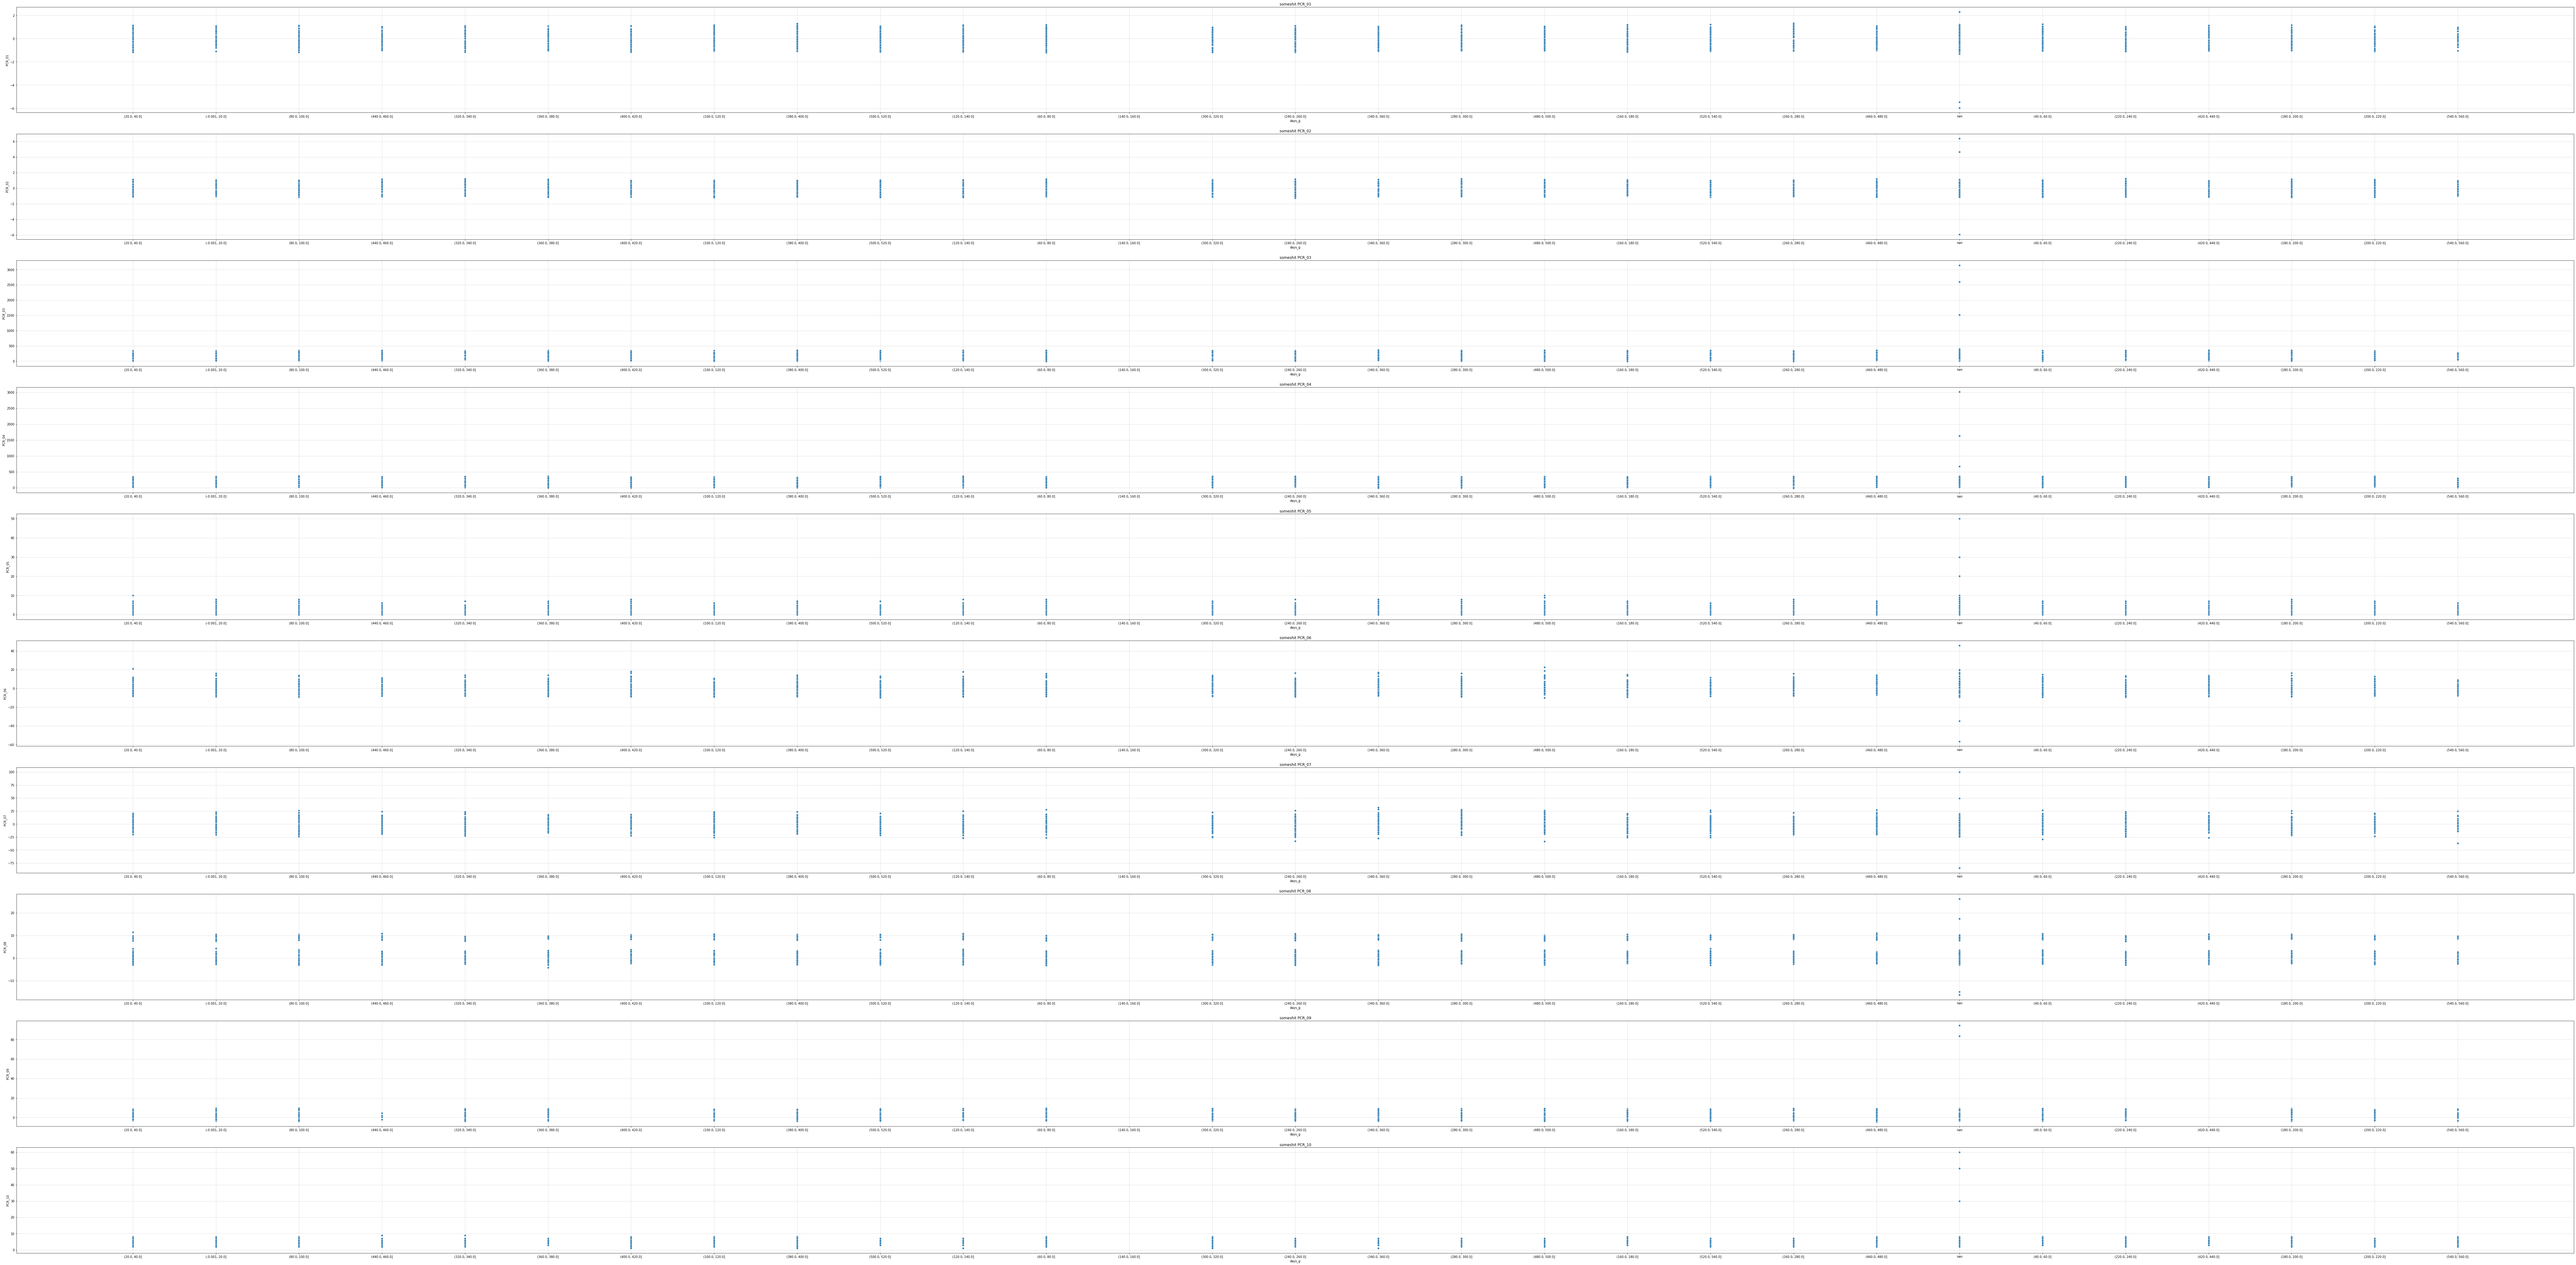

In [24]:
cleanIQR('age', 'weight')
genGroups()
cleanIQR('weight_g', 'age', True)
cleanIQR('sport_activity', 'sugar_levels')

#Goes to the pdf:
cleanIQR('age', 'household_income')
cleanIQR('conversations_per_day', 'happiness_score', True)# Happiness doesn't matter to conversations
cleanIQR('happiness_score', 'conversations_per_day', True)
cleanIQR('F', 'weight')
genGroups()
cleanIQR('weight_g', 'sugar_levels')
genGroups()

# PCRs:
# During the bad days there are pcr values that we cannot rely on

bad_days  = pd.Interval(140, 160, closed='right')
good_days = pd.Interval(60, 80, closed='right')

# Make all PCRs in bad days to have nan values
nanPCRs(bad_days)

# Cleaned PCRs grouped by day groups graphs: 
plt.figure(figsize=(150, 75))
for i, pcr in enumerate(pcr_list, 1):
  plt.subplot(10, 1, i)
  sns.scatterplot(x = train_data['days_g'].astype(str), y = train_data[pcr], palette = 'green').set_title('someshit ' + pcr)
  plt.grid(alpha=0.5)

# now clean the PCRs:
for pcr in ['PCR_01', 'PCR_02','PCR_03','PCR_04','PCR_05','PCR_06','PCR_07','PCR_10']:
  if pcr in pcr_dis: # discrete
    singleCleanIQR(pcr, True)
  else: singleCleanIQR(pcr)

nanPercent('PCR_08', 0.0009, 0.9994)
nanPercent('PCR_09', 0.0, 0.999)

genGroups()

In [25]:
clean_data = cp.deepcopy(train_data)

## Missing data treatment

In [26]:
def fillCoord(coord):
  mean = train_data[coord].mean()
  sig = train_data[coord].std()
  no_coord = train_data[train_data[coord].isna()]
  for i, row in no_coord.iterrows():
    train_data.at[i, coord] = np.random.normal(mean, sig)

def fillSex():
  # no sex => fill by age and weight median
  # no age => only by weight median
  # no weight =>  only by age median
  # no age no weight, or alone in group => flip a coin 
  medians1 = round(train_data.groupby(['age', 'weight_g']).agg({"F":[np.median]})['F']['median'])
  medians2 = round(train_data.groupby(['weight_g']).agg({"F":[np.median]})['F']['median'])
  medians3 = round(train_data.groupby(['age']).agg({"F":[np.median]})['F']['median'])
  no_sex = train_data[train_data.F.isna()]
  for i, row in no_sex.iterrows():
    age_val, weight_g_val = train_data.at[i, 'age'], train_data.at[i, 'weight_g']
    med1, med2, med3 = 'nan', 'nan', 'nan'
    F_val = np.nan
    if (age_val.astype(str) != 'nan'):
      if (weight_g_val.astype(str) != 'nan'):
        F_val = medians1[age_val][weight_g_val]
      else: # age, no weight
        F_val = medians3[age_val]
    else: # no age
      if (weight_g_val.astype(str) != 'nan'):
        F_val = medians2[weight_g_val]
    if F_val == np.nan:
      F_val = np.random.randint(0, high = 2 , size=1, dtype=int)
    train_data.at[i, 'F'] = F_val 

def fillAge():
  #no age with job => more than 16 yo => median of more than 16
  job_age_med = train_data[(train_data.age > 16)].age.median()
  mask = (train_data.age.isna())& (train_data.job.isna() == False)
  train_data.loc[mask, 'age'] = train_data.loc[mask, 'age'].fillna(job_age_med)
  
  #no age no job => fill by weight group median
  weight_g_meds = train_data.groupby(['weight_g']).agg({"age":[np.median]})['age']['median']
  no_age_no_job = train_data[(train_data.age.isna()) & (train_data.job.isna()) & (train_data.weight.isna() == False)]
  for i, row in no_age_no_job.iterrows():
    train_data.at[i, 'age'] = round(weight_g_meds[train_data.at[i, 'weight_g']])
                      
  # no age no job no weight => very few people => dont care => median age
  mask = (train_data.age.isna() & train_data.job.isna() & train_data.weight.isna())
  train_data.loc[mask, 'age'] = train_data.loc[mask, 'age'].fillna(round(train_data.age.median()))

def fillWeight():
  # no weight => fill by sex and age median
  ageF_g_meds = train_data.groupby(['age', 'F']).agg({"weight":[np.median]})['weight']['median']
  #print( ageF_g_meds)
  no_weight = train_data[train_data.weight.isna()]
  for i, row in no_weight.iterrows():
    train_data.at[i, 'weight'] = ageF_g_meds[train_data.at[i, 'age']][train_data.at[i, 'F']]
  
  # no age sex median => by age alone
  no_weight = train_data[train_data.weight.isna()]
  age_meds = train_data.groupby(['age']).agg({"weight":[np.median]})['weight']['median']
  for i, row in no_weight.iterrows():
    train_data.at[i, 'weight'] = age_meds[train_data.at[i, 'age']]
  genGroups()

def fillBlood():
  # Impute by mode of sex, age groups
  # No group => by sex alone
  blood_mode = train_data.groupby(['F', 'age']).agg({'blood_type':['value_counts']})['blood_type']['value_counts']
  F_blood_mode = train_data.groupby(['F']).agg({'blood_type':['value_counts']})['blood_type']['value_counts']
  no_blood = train_data[train_data.blood_type.isna()]
  for i, row in no_blood.iterrows():
    sex_val, age_val = train_data.at[i, 'F'], train_data.at[i, 'age']
    mode1 = blood_mode[sex_val][age_val].idxmax()
    mode2 = blood_mode[sex_val].idxmax()
    if mode1 != 'nan':
      train_data.at[i, 'blood_type'] = mode1
    else: 
      train_data.at[i, 'blood_type'] = mode2


def fillZip():
  # uniform 0501 -> 99999
  no_zip = train_data[(train_data.zip == 1)]
  for i, row in no_zip.iterrows():
    train_data.at[i, 'zip'] = np.random.randint(501, high = 10000 , size=1, dtype=int)
  # fill zip 
  genGroups()

def fillDays():
  # uniform min days -> max days
  no_date = train_data[(train_data.pcr_date.isna())]
  for i, row in no_date.iterrows():
    train_data.at[i, 'days'] = np.random.randint(train_data['days'].min(), high = train_data['days'].max(), size=1, dtype=int)
  # gen days_g
  genGroups()

def fillPCR(pcr): 
  # fill PCR by normal distribution of the whole dataset
  mean = train_data[pcr].mean()
  std =  train_data[pcr].std()/4
  quant = 0.999 # empirically reasonable
  top_percentile = train_data[pcr].quantile(quant) 
  min_percentle  = train_data[pcr].quantile(1 - quant) 
  for i, row in train_data.iterrows():
    if train_data.at[i, pcr].astype(str) == 'nan':
      rnd = np.random.normal(mean, std)
      while rnd >= top_percentile or rnd <= min_percentle:
        rnd = np.random.normal(mean, std)
      if pcr in pcr_positive and rnd < 0:
        rnd = 0
      if pcr in pcr_dis:  # PCR_05, PCR_10 are discrete
        rnd = round(rnd)
      train_data.at[i, pcr] = rnd

def fillPCR1ByPCR2(pcr1, pcr2): 
  # Fill PCR1 by medians of PCR2 groups with this PCR1 value
  pcr1_meds = train_data.groupby([pcr2]).agg({pcr1:[np.median]})[pcr1]['median']
  no_pcr1 = train_data[train_data[pcr1].astype(str) == 'nan']
  for i, row in no_pcr1.iterrows():
    pcr2_val = train_data.at[i, pcr2]
    pcr1_val = 'nan'
    if str(pcr2_val) != 'nan' and pcr1_meds[pcr2_val].astype(str) != 'nan' :
      pcr1_val = pcr1_meds[pcr2_val]
    if pcr1 in pcr_dis and pcr1_val != 'nan' : # for discrete PCRs
      pcr1_val = round(pcr1_val)
    train_data.at[i, pcr1] = pcr1_val


def fillNan(col_to_fill, emergency_col, to_round = False):
  # fill by every sex, age and weight_g group. If alone in one of the subgroups, use emergency_col 
  # from best to worst:
  medians1 = train_data.groupby(['F', 'age', 'weight_g']).agg({col_to_fill:[np.median]})[col_to_fill]['median']
  medians2 = train_data.groupby(['F', 'age']).agg({col_to_fill:[np.median]})[col_to_fill]['median']
  medians3 = train_data.groupby(['age', 'weight_g']).agg({col_to_fill:[np.median]})[col_to_fill]['median']
  medians4 = train_data.groupby(['F', 'weight_g']).agg({col_to_fill:[np.median]})[col_to_fill]['median']
  medians5 = train_data.groupby([emergency_col]).agg({col_to_fill:[np.median]})[col_to_fill]['median']

  for i, row in train_data.iterrows():
    if train_data.at[i, col_to_fill].astype(str) == 'nan':
      sex_val, age_val, weight_g_val, emer_val = \
      train_data.at[i, 'F'], train_data.at[i, 'age'], train_data.at[i, 'weight_g'],  train_data.at[i, emergency_col]
      med1 = medians1[sex_val][age_val][weight_g_val]
      med2 = medians2[sex_val][age_val]
      med3 = medians3[age_val][weight_g_val]
      med4 = medians4[sex_val][weight_g_val]
      med5 = medians5[emer_val]
      med_list = [med1, med2, med3, med4, med5]
      for j in range(len(med_list)):
        if med_list[j].astype(str) != 'nan':
          train_data.at[i, col_to_fill] = round(med_list[j]) if to_round else med_list[j]
          break

# Sex, age and weight are reliable group selection for other features
# Therefore impute them first
fillSex()  
fillAge()
fillWeight()

fillBlood()
#Fill OHE blood features:
blood_type_ohe = pd.get_dummies(train_data['blood_type'])
train_data = train_data.join(blood_type_ohe)


fillZip()
fillDays()
fillCoord('x')
fillCoord('y')

# impute by median of sex, age and weight groups

fill_by_med_to_round = [
       'num_of_siblings', 'happiness_score', 
       'conversations_per_day', 'sport_activity']
fill_by_med = ['household_income', 'sugar_levels']

for col_to_fill in fill_by_med:
  fillNan(col_to_fill, 'F')

for col_to_fill in fill_by_med_to_round:
  fillNan(col_to_fill, 'F', True)

genGroups()

# Impute PCRS:
# Impute dependent PCRs by one another:
fillPCR1ByPCR2('PCR_01', 'PCR_02_g')
genGroups()
fillPCR1ByPCR2('PCR_02', 'PCR_01_g')
genGroups()

fillPCR1ByPCR2('PCR_05', 'PCR_06_g')
genGroups()
fillPCR1ByPCR2('PCR_06', 'PCR_05')
genGroups()



fillPCR1ByPCR2('PCR_03', 'PCR_04_g')
genGroups()
fillPCR1ByPCR2('PCR_04', 'PCR_03_g')
genGroups()


# fill the rest by normal distribution of the PCR:
for pcr in pcr_list:
  fillPCR(pcr)
  genGroups()

In [27]:
filled_data = cp.deepcopy(train_data)

In [28]:
drop_list = ['blood_type', 'address', 'current_location', 'job', 'pcr_date', 'M', 'weight_g', 'household_income_g', 'sugar_levels_g', 'days_g', 'zip_g', 'PCR_01_mark']

## Findings and dependencies of the preprocessed data visualizations: 

<Figure size 720x432 with 0 Axes>

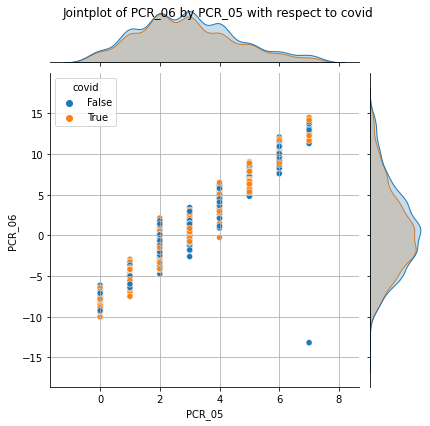

In [29]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='covid', x='PCR_05', y='PCR_06')
g.fig.suptitle("Jointplot of PCR_06 by PCR_05 with respect to covid")
_ = g.ax_joint.grid()

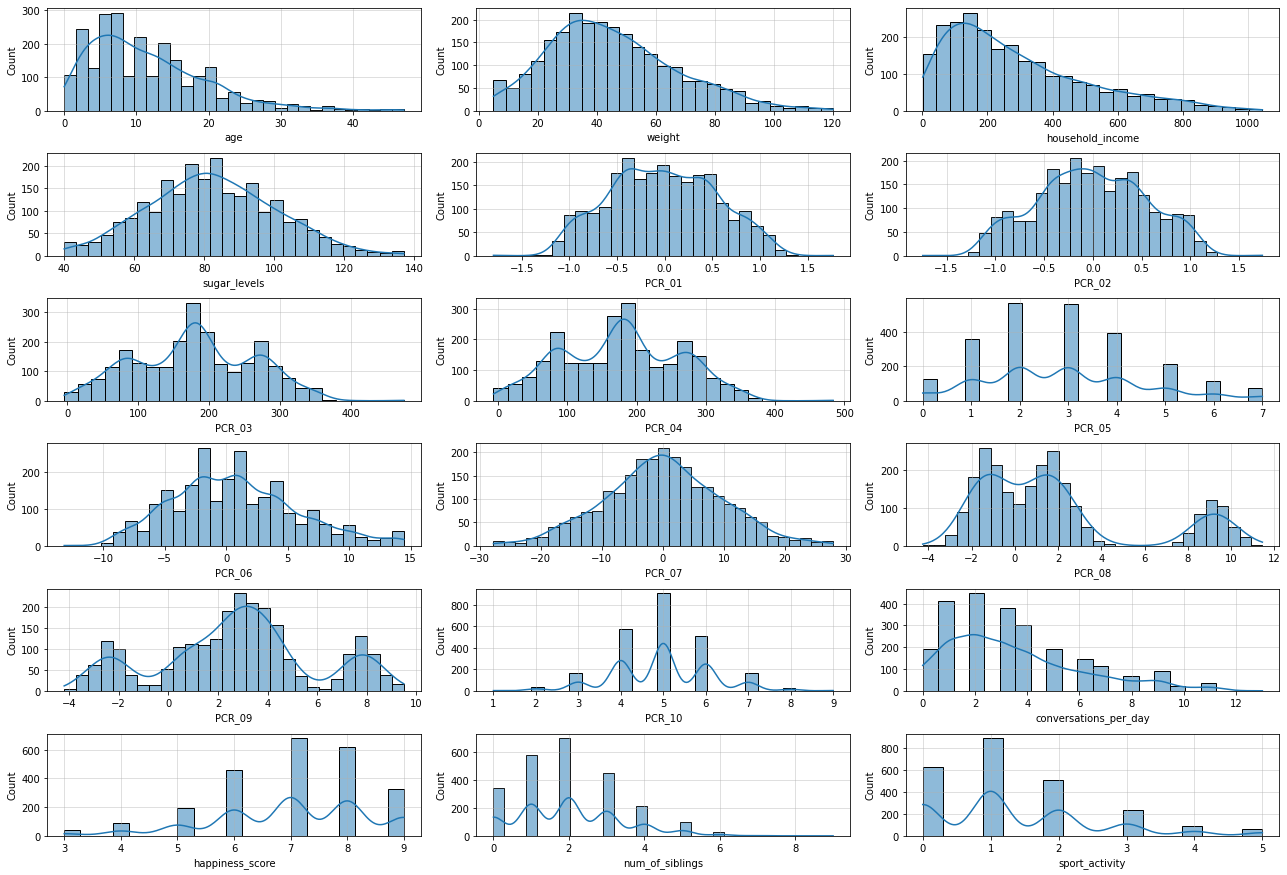

In [30]:
histograms(filled_data)

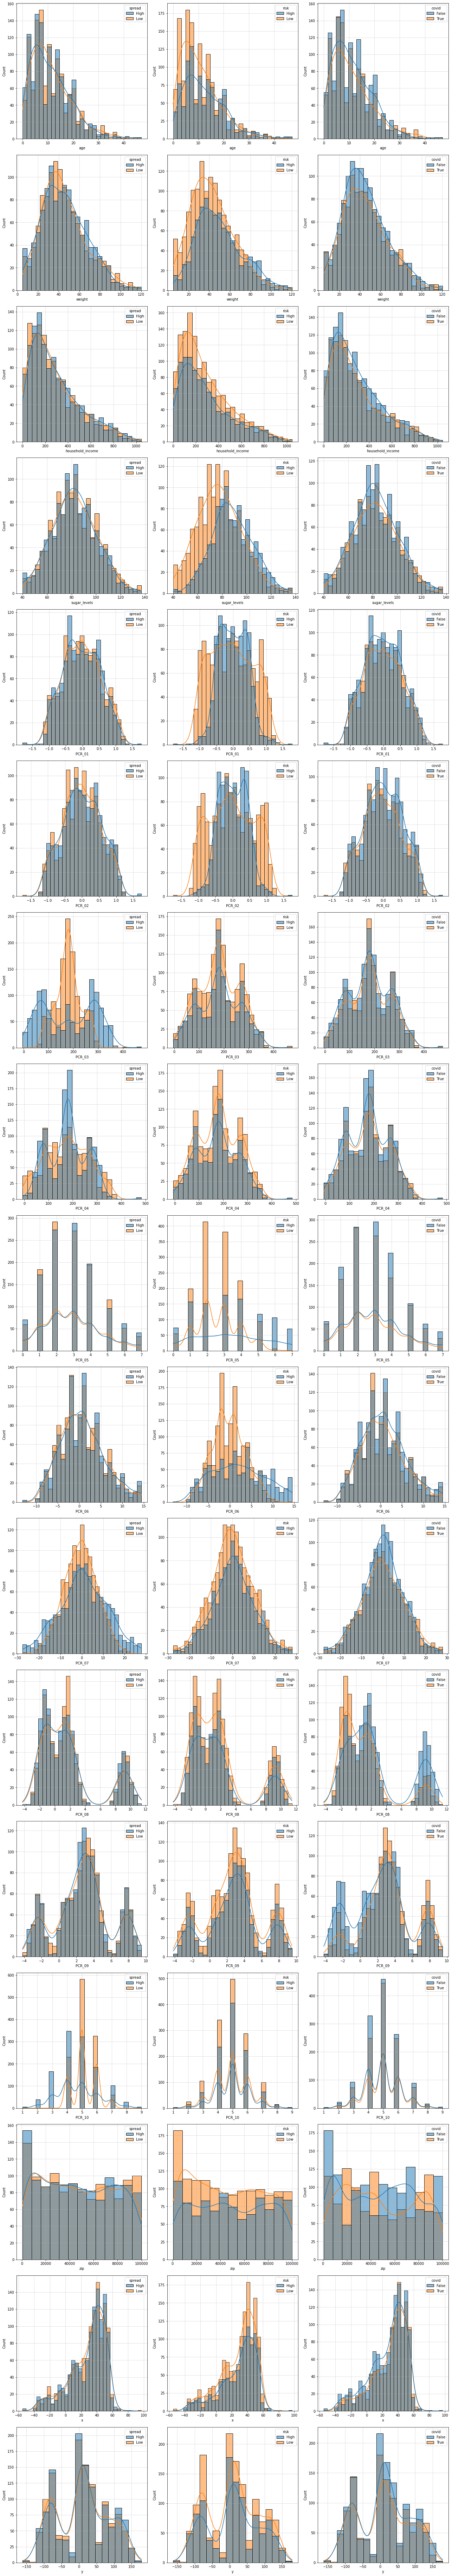

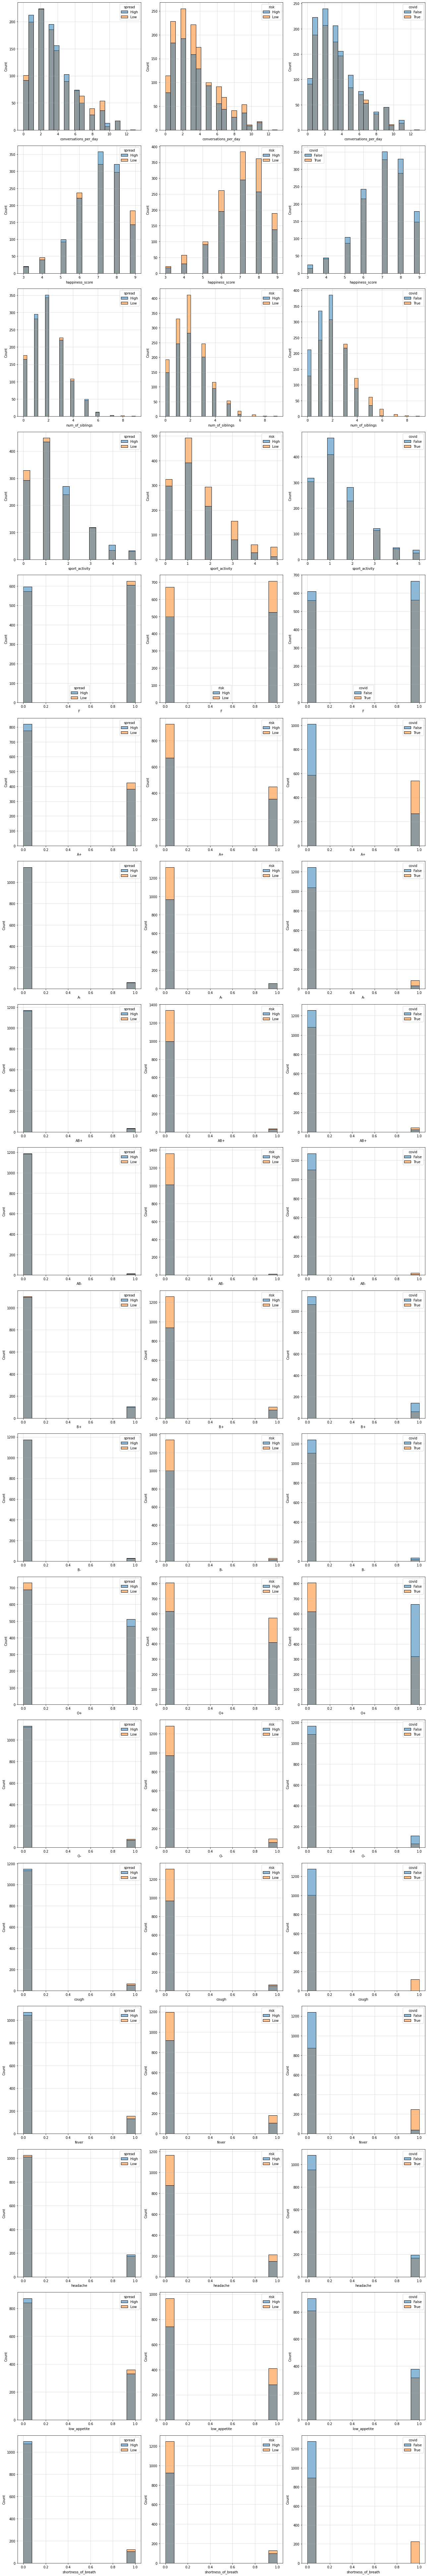

In [31]:
COL_CONT = ['age', 'weight', 'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'zip','x', 'y']
COL_TARGET = ['spread', 'risk', 'covid']
COL_NOT_USED = ['patient_id', 'address', 'current_location', 'job', 'pcr_date']
COL_CAT = ['conversations_per_day', 'happiness_score', 'num_of_siblings', 'sport_activity','F', 'A+', 'A-', 'AB+', 'AB-',
       'B+', 'B-', 'O+', 'O-', 'cough', 'fever', 'headache', 'low_appetite',
       'shortness_of_breath']
COLS = 3

#CONTINUOUS COLUMNS:
ROWS = len(COL_CONT)

plt.figure(figsize=(18, 6 * ROWS))
for i, column in enumerate(COL_CONT, 1):
  for j, target in enumerate(COL_TARGET, 1):
     plt.subplot(ROWS, COLS, (i-1)*3 + j)
     sns.histplot(data=filled_data, hue=target, x=column, multiple='layer', kde=True)
     plt.grid(alpha=0.5)

plt.tight_layout()

#OTHER COLUMNS:
ROWS = len(COL_CAT)

plt.figure(figsize=(18, 6 * ROWS))
for i, column in enumerate(COL_CAT, 1):
  for j, target in enumerate(COL_TARGET, 1):
     plt.subplot(ROWS, COLS, (i-1)*3 + j)
     sns.histplot(data=filled_data, hue=target, x=column, multiple='layer')
     plt.grid(alpha=0.5)

plt.tight_layout()

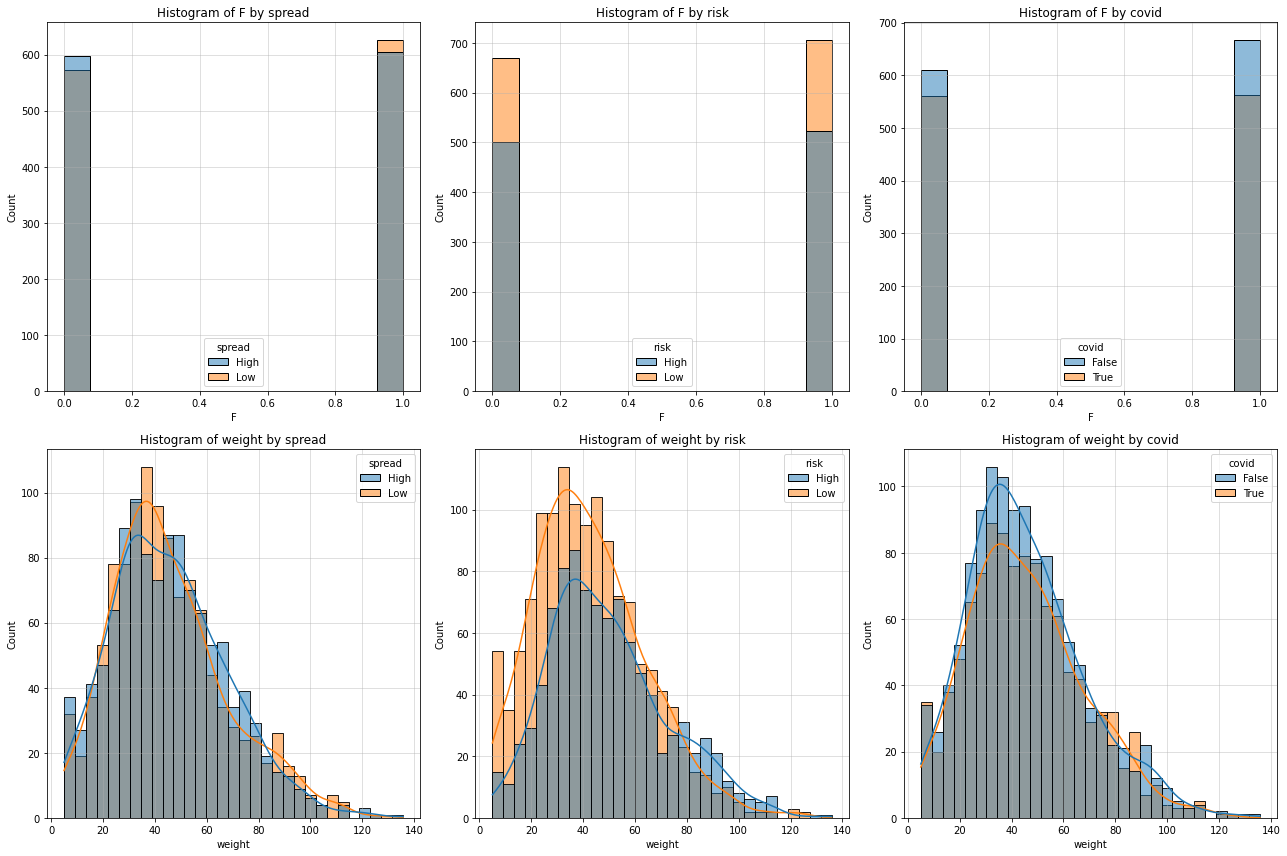

In [32]:
 plt.figure(figsize=(18, 6 * 2))

for j, target in enumerate(COL_TARGET, 1):
  plt.subplot(2, 3, j)
  sns.histplot(data= orig_data, hue=target, x='F', multiple='layer', kde=False).set_title("Histogram of F by " + target)
  plt.grid(alpha=0.5)

for j, target in enumerate(COL_TARGET, 1):
  plt.subplot(2, 3, 3 + j)
  sns.histplot(data= orig_data, hue=target, x='weight', multiple='layer', kde = True).set_title("Histogram of weight by " + target)
  plt.grid(alpha=0.5)


plt.tight_layout()

In [33]:
# Correlation table
filled_data.corr()


patient_id       age    weight  num_of_siblings  \
patient_id               1.000000  0.015343  0.023779        -0.036387   
age                      0.015343  1.000000  0.809666        -0.005013   
weight                   0.023779  0.809666  1.000000        -0.017485   
num_of_siblings         -0.036387 -0.005013 -0.017485         1.000000   
happiness_score         -0.012658  0.013919 -0.007665        -0.023459   
household_income         0.005367  0.060469  0.047053         0.023497   
conversations_per_day    0.002523 -0.007940 -0.011323         0.007346   
sugar_levels             0.030240  0.478501  0.585477        -0.016553   
sport_activity           0.009548 -0.179303 -0.204533         0.014550   
PCR_01                   0.021753  0.054470  0.029927        -0.032856   
PCR_02                   0.035110  0.060120  0.048918        -0.039558   
PCR_03                  -0.002039 -0.016192 -0.010404        -0.014659   
PCR_04                   0.006382 -0.010243 -0.028841         0.013523   
PCR_05                  -0.000470 -0.010998 -0.001882         0.004345   
PCR_06                  -0.010551 -0.016124 -0.003561         0.004526   
PCR_07                   0.006556  0.009160  0.008100        -0.038230   
PCR_08                   0.011167  0.014537  0.021247        -0.019815   
PCR_09                   0.024942 -0.015707 -0.017027         0.026121   
PCR_10                   0.025362 -0.000170  0.012852         0.006935   
covid                   -0.014234 -0.003182 -0.000158         0.162369   
cough                   -0.025522 -0.006784 -0.020805        -0.014070   
fever                   -0.005808  0.009736  0.021741        -0.005111   
headache                 0.015605 -0.021266 -0.058394        -0.013292   
low_appetite             0.023325 -0.008689 -0.028971         0.040822   
shortness_of_breath     -0.037959 -0.001223 -0.011570        -0.011564   
F                       -0.010627 -0.030528 -0.134965        -0.026079   
M                        0.009645  0.026168  0.132154         0.042245   
zip                     -0.004804  0.020806  0.007837         0.033832   
x                        0.000902 -0.012010 -0.033542        -0.014381   
y                        0.016444  0.002407 -0.005772         0.017316   
days                    -0.011240  0.003443 -0.002456         0.003674   
A+                      -0.004523  0.041259  0.037710         0.008289   
A-                       0.040073  0.003209 -0.001022        -0.018203   
AB+                     -0.013303  0.029236  0.047936        -0.018712   
AB-                     -0.026031 -0.014920 -0.011598         0.015683   
B+                       0.000100  0.003548 -0.002199         0.034029   
B-                       0.013459 -0.010178 -0.012082         0.009854   
O+                      -0.001119 -0.050970 -0.043006        -0.014562   
O-                      -0.013089  0.009162 -0.002569        -0.009708   

                       happiness_score  household_income  \
patient_id                   -0.012658          0.005367   
age                           0.013919          0.060469   
weight                       -0.007665          0.047053   
num_of_siblings              -0.023459          0.023497   
happiness_score               1.000000         -0.001305   
household_income             -0.001305          1.000000   
conversations_per_day         0.024540          0.022027   
sugar_levels                  0.016781          0.014004   
sport_activity               -0.014874         -0.006503   
PCR_01                       -0.016258          0.014641   
PCR_02                        0.017607         -0.007592   
PCR_03                        0.046743         -0.039645   
PCR_04                       -0.025434         -0.018939   
PCR_05                       -0.014555         -0.028861   
PCR_06                       -0.009547         -0.031498   
PCR_07                        0.008212          0.021051   
PCR_08                       -0.028244    

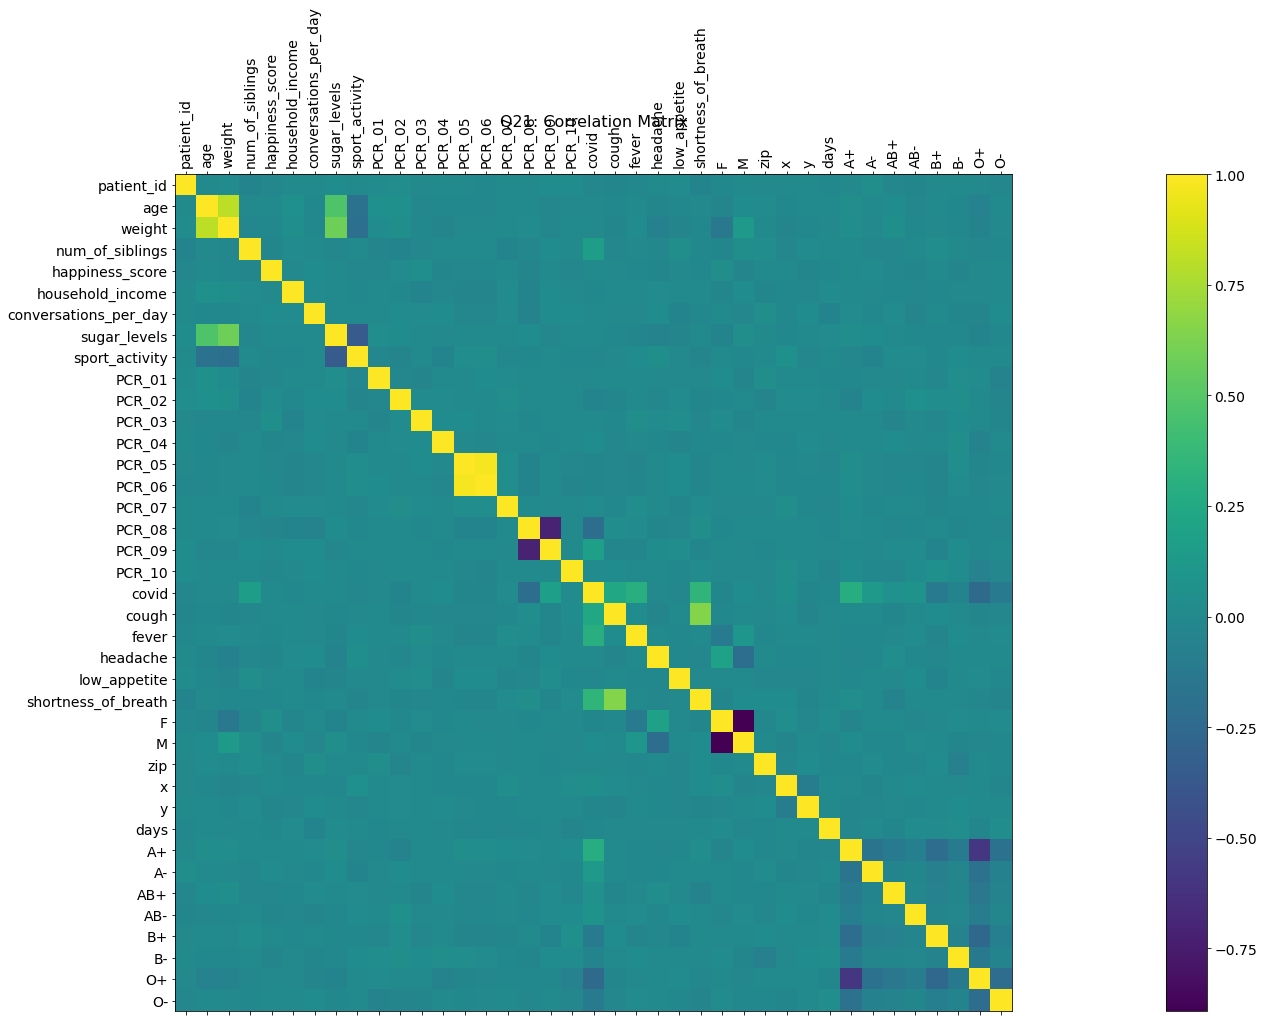

In [34]:
def plotCorrMatrix(df, title):
  corr = df.corr()
  f = plt.figure(figsize=(55, 15))
  plt.matshow(corr, fignum=f.number)
  plt.xticks(range(len(corr.columns)), corr.columns, fontsize=14, rotation=90)
  plt.yticks(range(len(corr.columns)), corr.columns, fontsize=14)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title(title, fontsize=16);

plotCorrMatrix(train_data, 'Q21: Correlation Matrix')

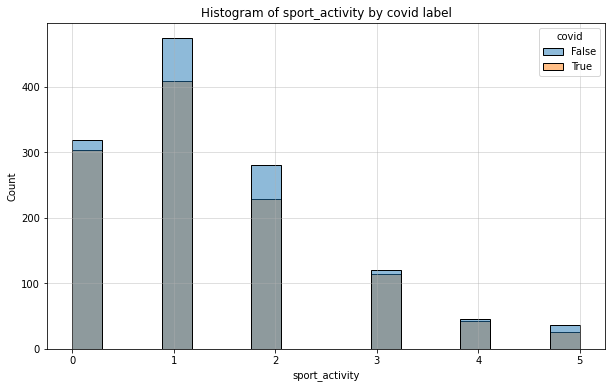

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(train_data, x='sport_activity', hue='covid').set_title('Histogram of sport_activity by covid label')
plt.grid(alpha=0.5)

<Figure size 720x432 with 0 Axes>

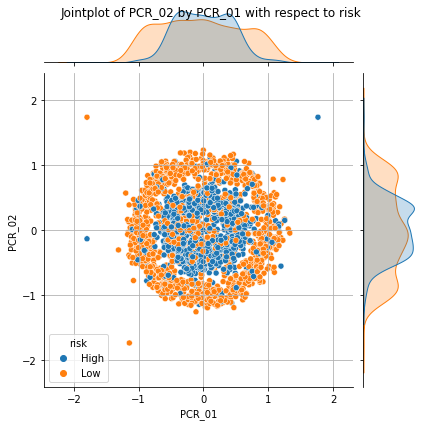

In [36]:
#Q21
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='risk', x='PCR_01', y='PCR_02')
g.fig.suptitle("Jointplot of PCR_02 by PCR_01 with respect to risk")
_ = g.ax_joint.grid()

<Figure size 720x432 with 0 Axes>

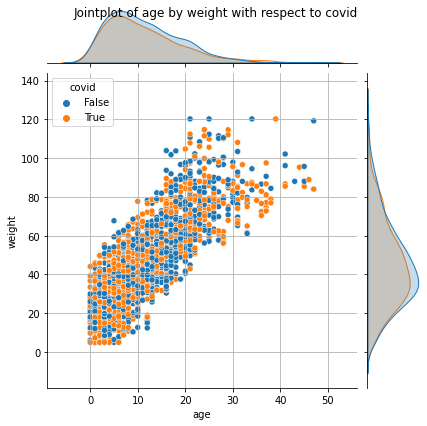

In [37]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='covid', x='age', y='weight')
g.fig.suptitle("Jointplot of age by weight with respect to covid")
_ = g.ax_joint.grid()

<Figure size 720x432 with 0 Axes>

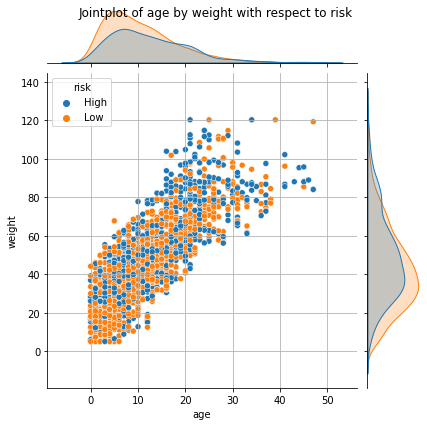

In [38]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='risk', x='age', y='weight')
g.fig.suptitle("Jointplot of age by weight with respect to risk")
_ = g.ax_joint.grid()

<Figure size 720x432 with 0 Axes>

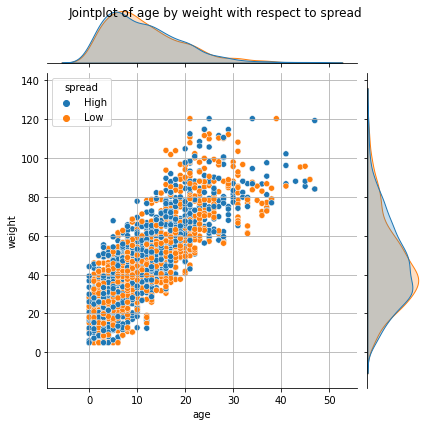

In [39]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='spread', x='age', y='weight')
g.fig.suptitle("Jointplot of age by weight with respect to spread")
_ = g.ax_joint.grid()

<Figure size 720x432 with 0 Axes>

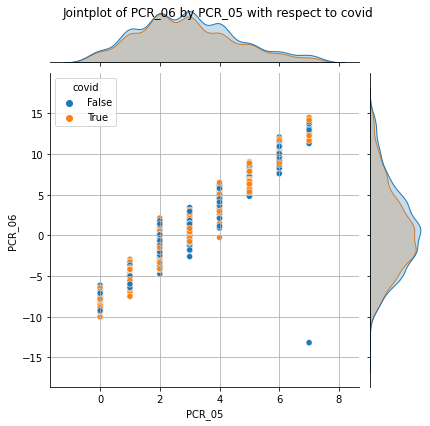

<Figure size 720x432 with 0 Axes>

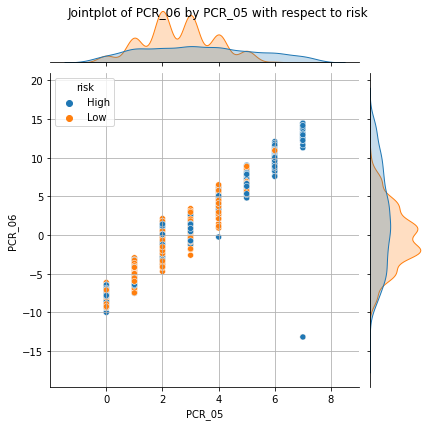

<Figure size 720x432 with 0 Axes>

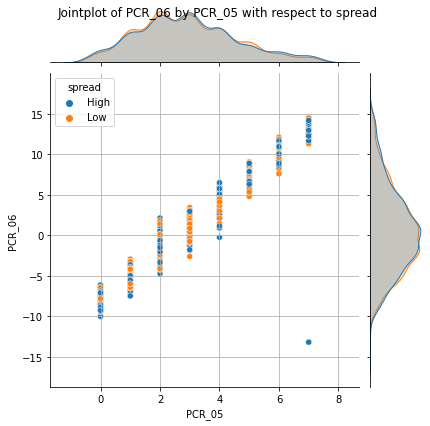

In [40]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='covid', x='PCR_05', y='PCR_06')
g.fig.suptitle("Jointplot of PCR_06 by PCR_05 with respect to covid")
_ = g.ax_joint.grid()

plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='risk', x='PCR_05', y='PCR_06')
g.fig.suptitle("Jointplot of PCR_06 by PCR_05 with respect to risk")
_ = g.ax_joint.grid()

plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, hue='spread', x='PCR_05', y='PCR_06')
g.fig.suptitle("Jointplot of PCR_06 by PCR_05 with respect to spread")
_ = g.ax_joint.grid()

<Figure size 720x432 with 0 Axes>

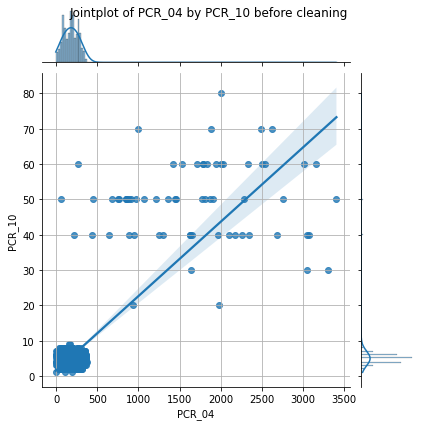

<Figure size 720x432 with 0 Axes>

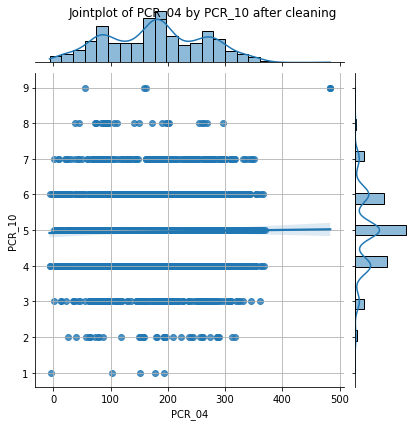

In [41]:
plt.figure(figsize=(10, 6))
g = sns.jointplot(data=orig_data, x='PCR_04', y='PCR_10', kind='reg')
g.fig.suptitle("Jointplot of PCR_04 by PCR_10 before cleaning")
_ = g.ax_joint.grid()

plt.figure(figsize=(10, 6))
g = sns.jointplot(data=train_data, x='PCR_04', y='PCR_10', kind='reg')
g.fig.suptitle("Jointplot of PCR_04 by PCR_10 after cleaning")
_ = g.ax_joint.grid()

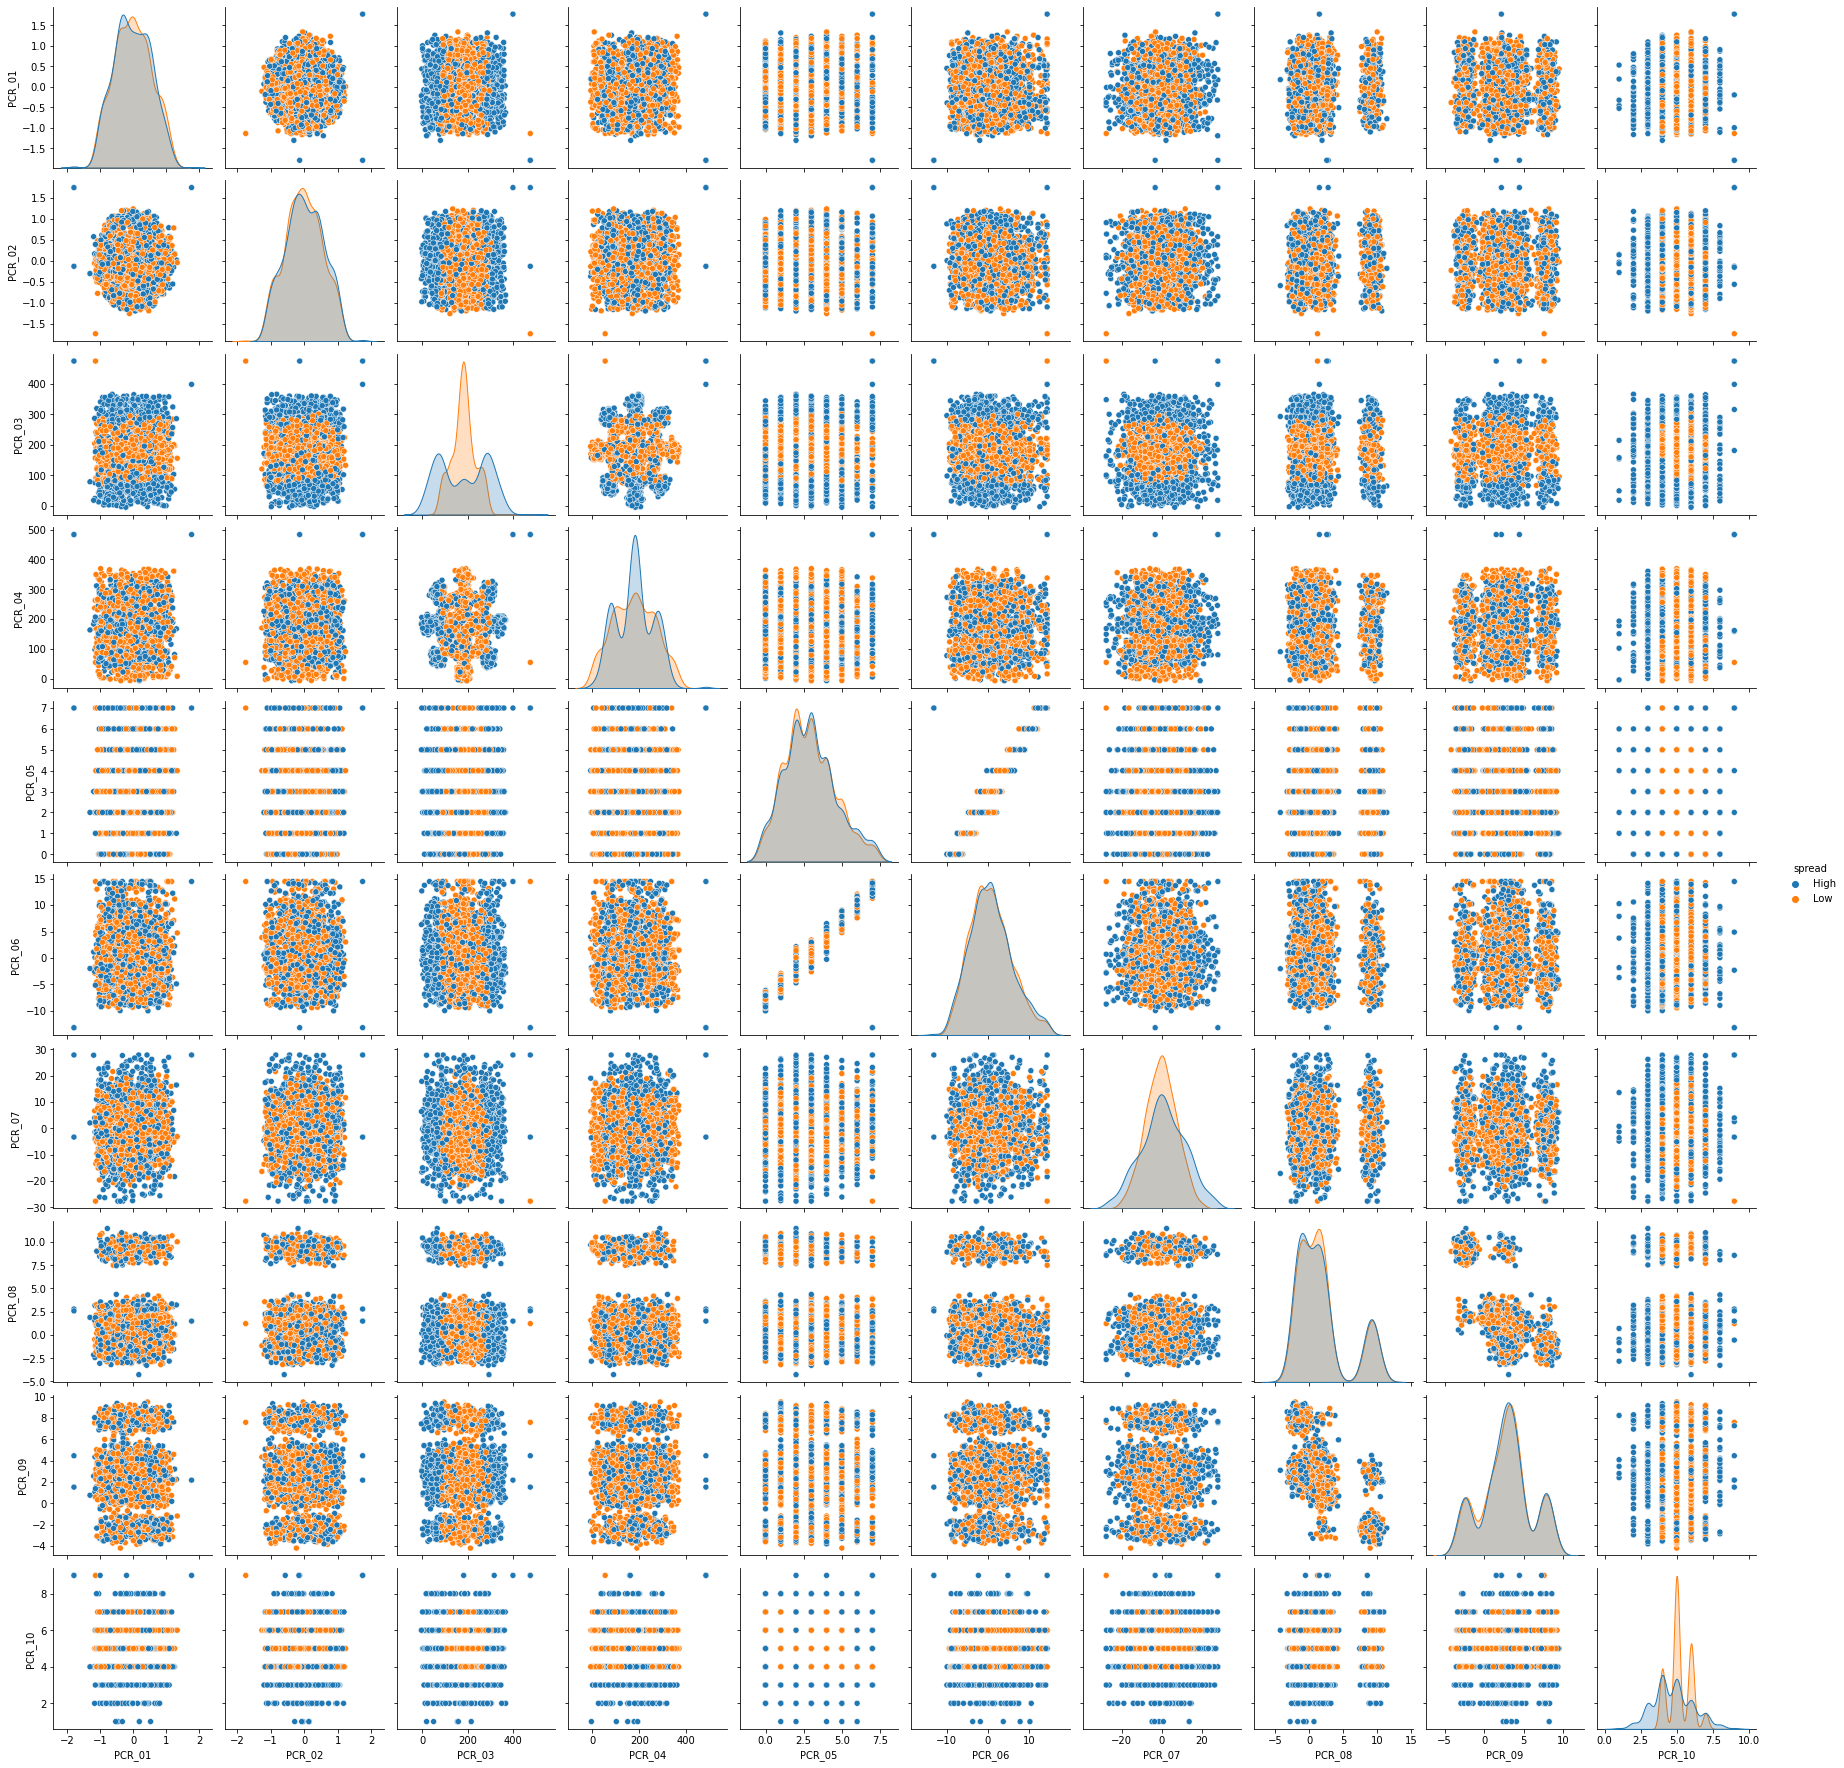

In [42]:
sns.pairplot(data = filled_data[pcr_list + ['spread']], hue = 'spread')

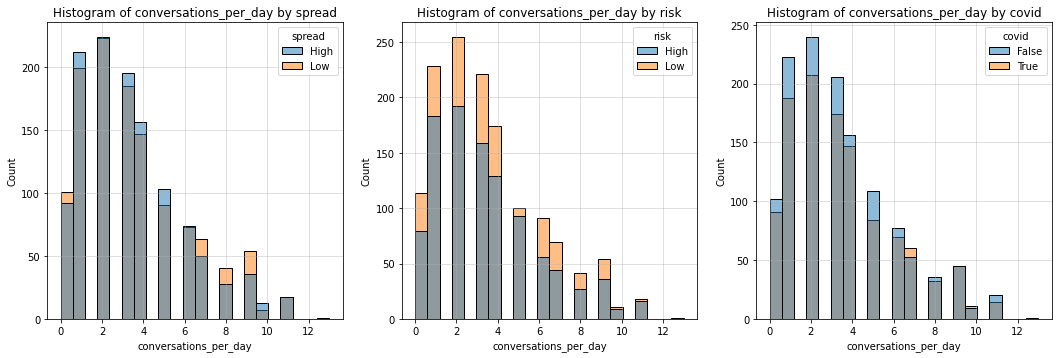

In [43]:
plt.figure(figsize=(18, 6 * 2))
for j, target in enumerate(COL_TARGET, 1):
  plt.subplot(2, 3, j)
  sns.histplot(data= train_data, hue=target, x='conversations_per_day').set_title("Histogram of conversations_per_day by " + target)
  plt.grid(alpha=0.5)

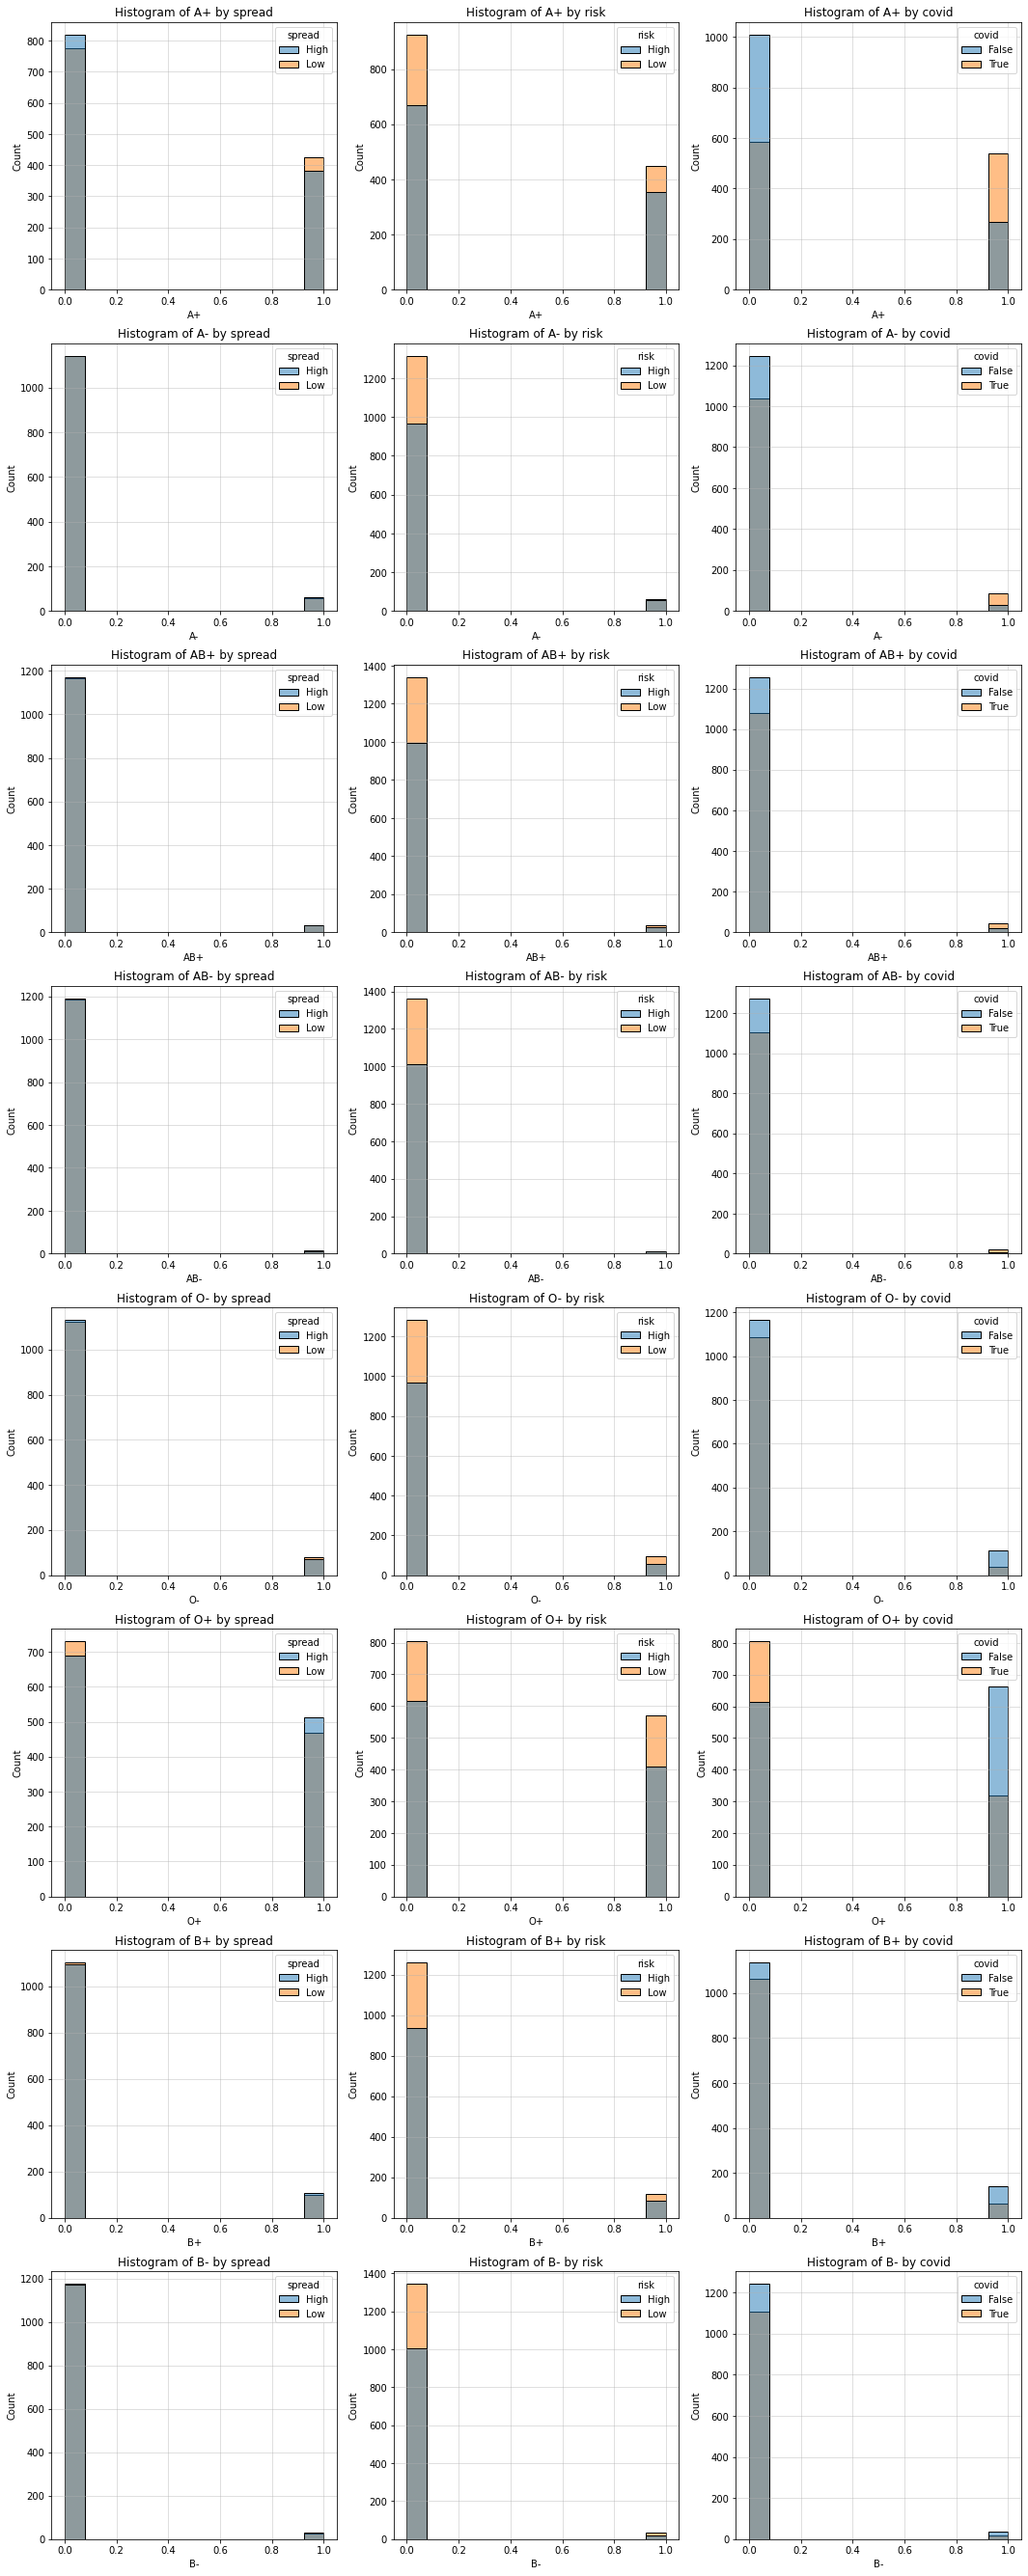

In [44]:
plt.figure(figsize=(18, 6 * 8))
blood_types=['A+', 'A-', 'AB+', 'AB-', 'O-', 'O+', 'B+', 'B-']
for i, col in enumerate(blood_types, 0):
  for j, target in enumerate(COL_TARGET, 1):
    plt.subplot(len(blood_types), 3, i*3 + j)
    sns.histplot(data= train_data, hue=target, x=col).set_title("Histogram of " + col +" by " + target)
    plt.grid(alpha=0.5)